# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 1024 # Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00005
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")

# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [7]:
df

mj1         mj2          mjj   tau21j1   tau21j2
0       559.577026  389.674988  4913.432129  0.551543  0.302850
1       217.050995  121.789001  3231.113770  0.680655  0.419944
2       130.710999  115.191002  2820.755615  0.452259  0.639433
3       462.013000   42.474201  2535.666748  0.219083  0.531491
4       219.542007  101.137001  4313.622070  0.217244  0.531440
...            ...         ...          ...       ...       ...
999419  796.106995   32.149200  3173.365967  0.495325  0.770408
999420  333.614014  124.994003  3933.395508  0.713051  0.298112
999421  420.259003   77.524902  3262.257812  0.194199  0.600804
999422  632.781006  189.417999  3372.129150  0.209634  0.705832
999423  150.893997  100.477997  3682.832031  0.627940  0.276693

[999424 rows x 5 columns]

In [8]:
# Normalize all inputs between -1 and 1

train_features = ["mj1",'mj2','tau21j1','tau21j2']
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 732 batches of 1024 samples each, total 749568 samples
Testset consists of 244 batches of 1024 samples each, total 249856 samples


0

In [9]:
X_train

array([[-0.642245  , -0.8018942 ,  0.02558839,  0.6040051 ],
       [-0.88001597, -0.8767271 ,  0.1947794 ,  0.64443815],
       [-0.689919  , -0.9274177 ,  0.1103611 ,  0.05989301],
       ...,
       [-0.53355825, -0.56106365,  0.16050172,  0.17293704],
       [-0.77268004, -0.80781484,  0.11753178,  0.6995535 ],
       [-0.7722119 , -0.92345434,  0.24101126,  0.68177044]],
      dtype=float32)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [12]:
generator = make_generator_model()

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(4)) # WGAN: No sigmoid activation in last layer

    return model

In [14]:
discriminator = make_discriminator_model()

In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                250       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [16]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                250       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

In [17]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [18]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [19]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [20]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [21]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [22]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [23]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.normal([BATCH_SIZE,len(train_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [24]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [25]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.normal([BATCH_SIZE,len(train_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [39]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    mj1=[]
    mj2=[]
    tau21j1=[]
    tau21j2=[]
    for i in fakedata:
        mj1.append(i[0])
        mj2.append(i[1])
        tau21j1.append(i[2])
        tau21j2.append(i[3])
    plt.subplot(221)
    plt.hist(df['mj1'], bins = 50, range = (0, 1000), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(mj1, bins = 50, range = (0, 1000), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.subplot(222)
    plt.hist(df['mj2'], bins = 50, range = (0, 500), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(mj2, bins = 50, range = (0, 500), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.subplot(223)
    plt.hist(df['tau21j1'], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(tau21j1, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.subplot(224)
    plt.hist(df['tau21j2'], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(tau21j2, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [27]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [28]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [29]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [42]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = False #((epoch + 10) % 20 == 0)
    draw_outputs = ((epoch + 1) % 10 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)


    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging
    
    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()

  1%|▋                                                                              | 9/1000 [01:18<2:25:43,  8.82s/it]


Epoch 10:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


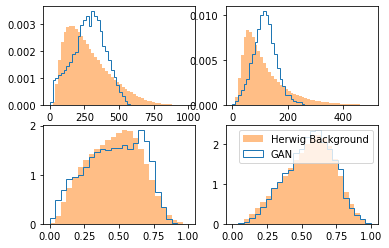

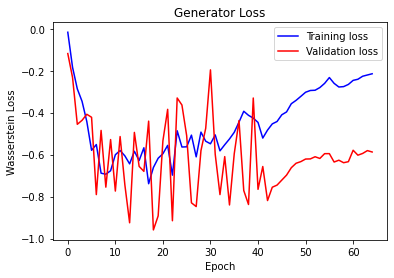

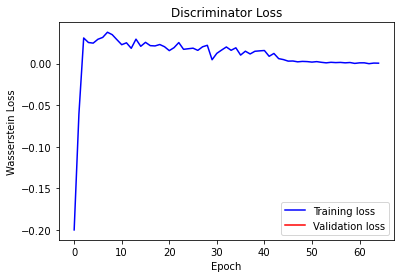

  2%|█▍                                                                            | 19/1000 [02:47<2:21:13,  8.64s/it]


Epoch 20:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


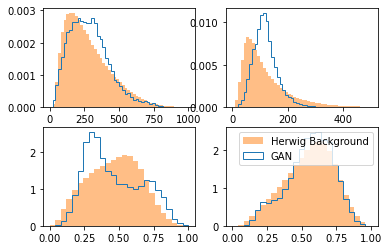

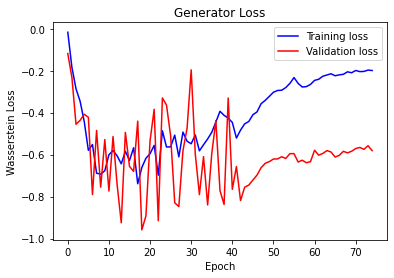

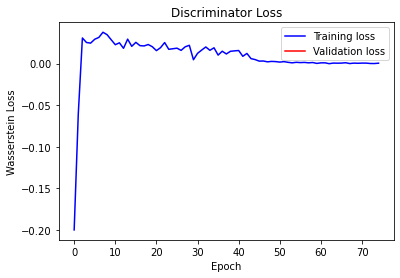

  3%|██▎                                                                           | 29/1000 [04:16<2:22:32,  8.81s/it]


Epoch 30:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


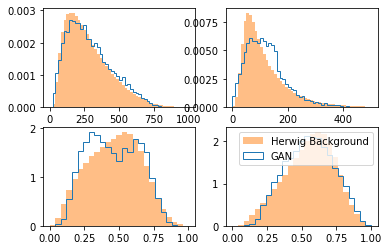

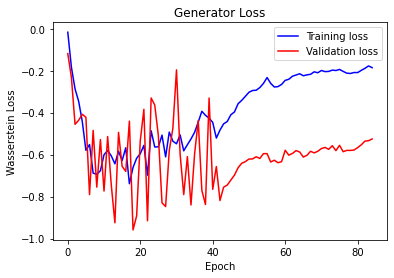

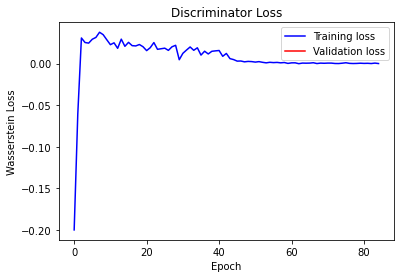

  4%|███                                                                           | 39/1000 [05:46<2:24:27,  9.02s/it]


Epoch 40:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


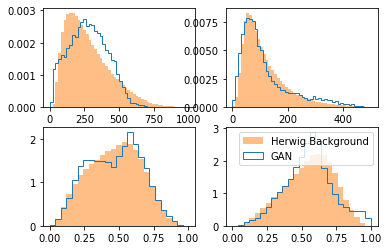

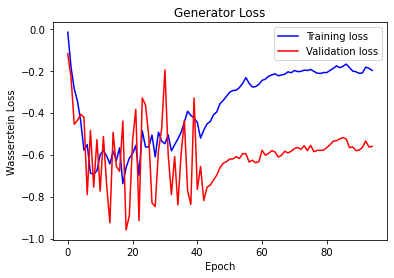

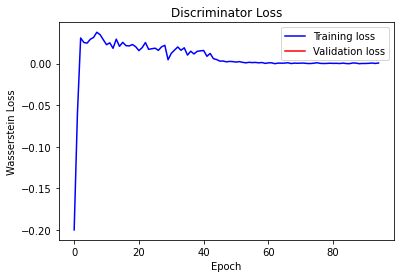

  5%|███▊                                                                          | 49/1000 [07:18<2:23:29,  9.05s/it]


Epoch 50:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


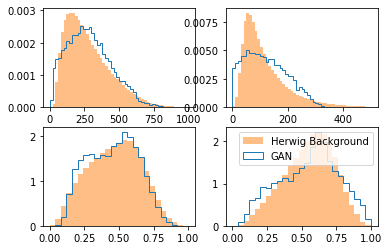

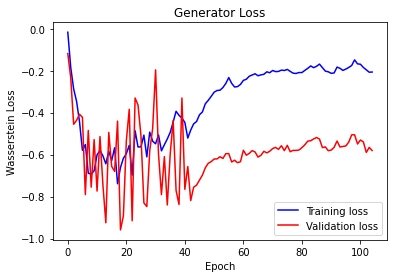

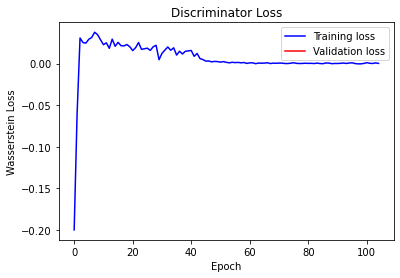

  6%|████▌                                                                         | 59/1000 [09:28<3:34:43, 13.69s/it]


Epoch 60:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


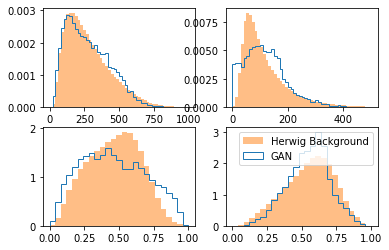

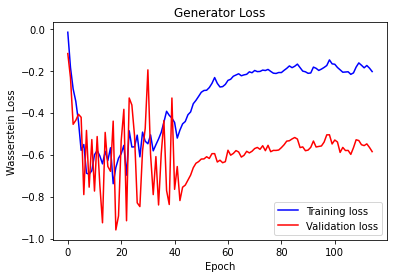

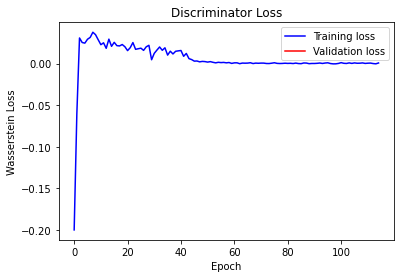

  7%|█████▍                                                                        | 69/1000 [11:15<2:29:29,  9.63s/it]


Epoch 70:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


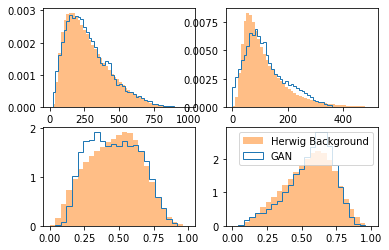

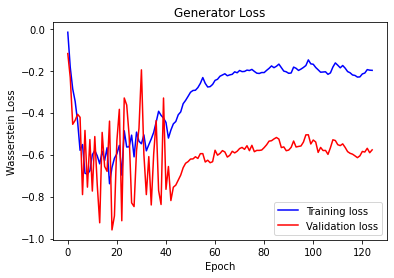

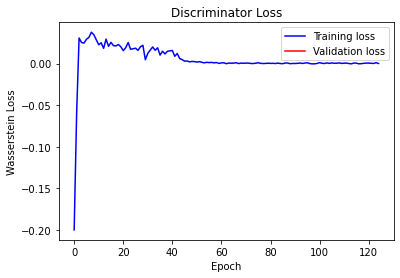

  8%|██████▏                                                                       | 79/1000 [12:47<2:17:17,  8.94s/it]


Epoch 80:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


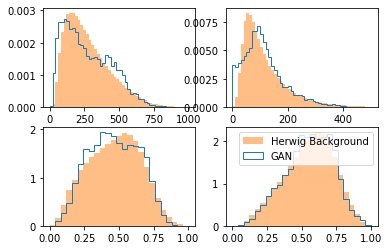

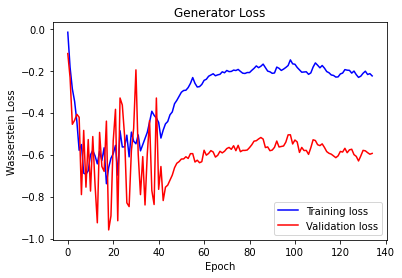

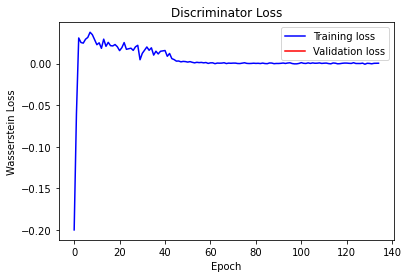

  9%|██████▉                                                                       | 89/1000 [14:16<2:12:48,  8.75s/it]


Epoch 90:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


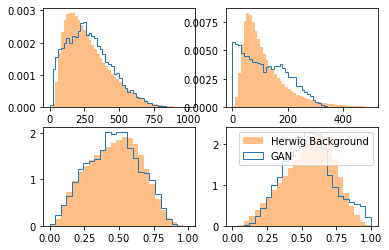

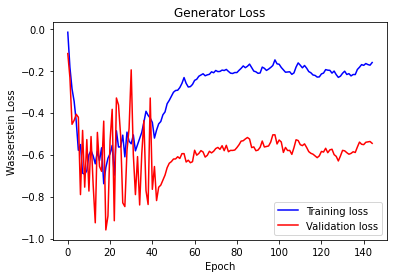

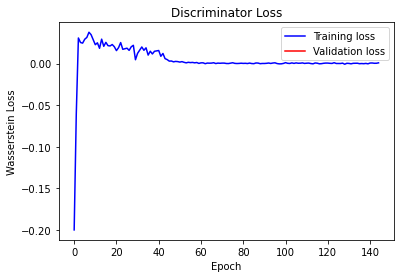

 10%|███████▋                                                                      | 99/1000 [15:52<2:23:31,  9.56s/it]


Epoch 100:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


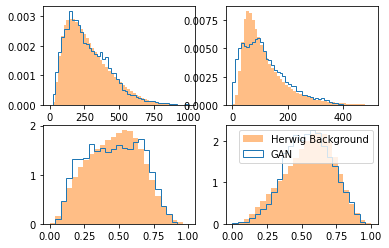

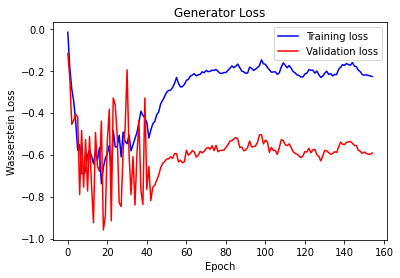

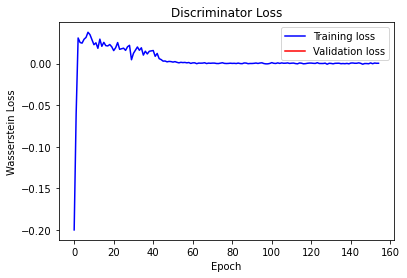

 11%|████████▍                                                                    | 109/1000 [17:36<2:54:07, 11.73s/it]


Epoch 110:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


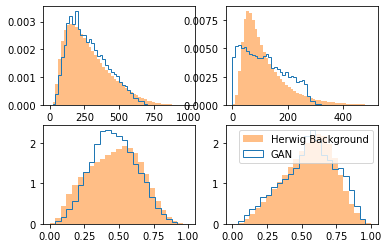

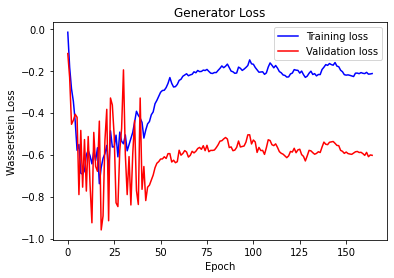

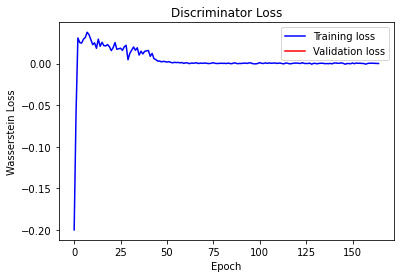

 12%|█████████▏                                                                   | 119/1000 [19:57<3:25:53, 14.02s/it]


Epoch 120:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


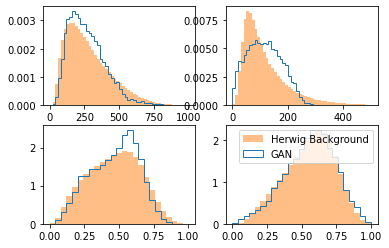

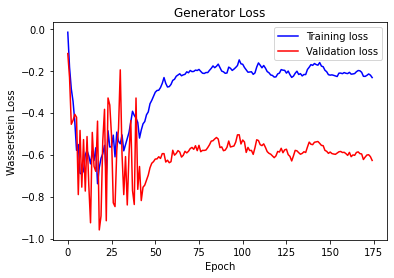

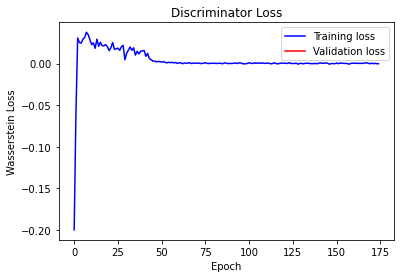

 13%|█████████▉                                                                   | 129/1000 [22:15<3:21:42, 13.90s/it]


Epoch 130:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


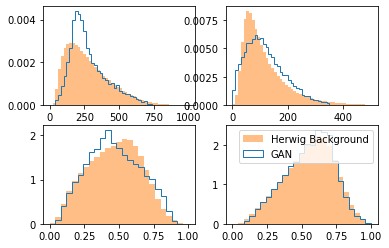

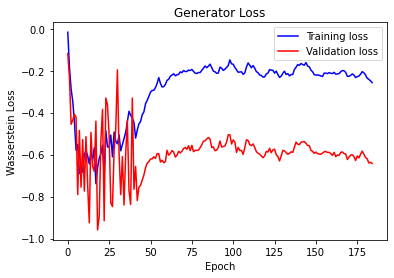

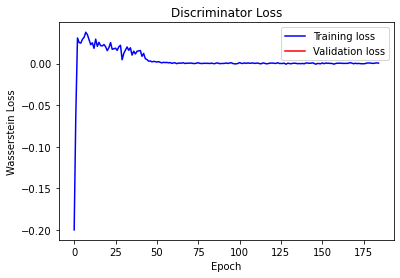

 14%|██████████▋                                                                  | 139/1000 [24:23<3:08:51, 13.16s/it]


Epoch 140:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


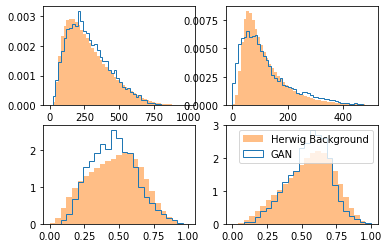

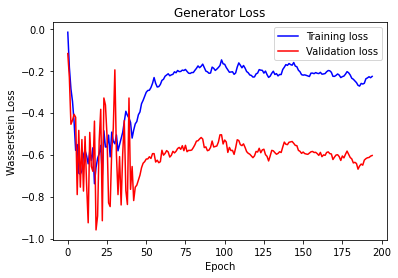

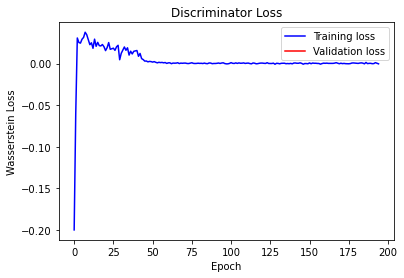

 15%|███████████▍                                                                 | 149/1000 [26:41<3:15:27, 13.78s/it]


Epoch 150:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


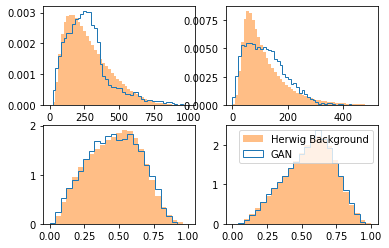

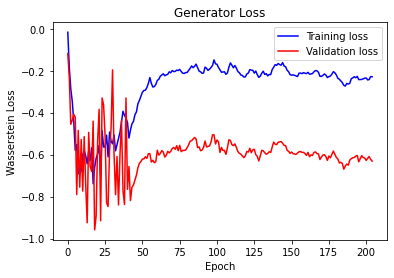

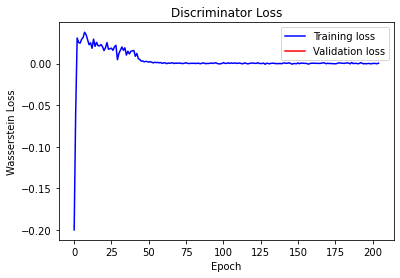

 16%|████████████▏                                                                | 159/1000 [29:03<3:18:59, 14.20s/it]


Epoch 160:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


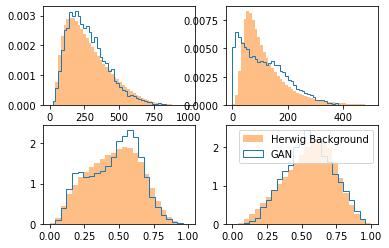

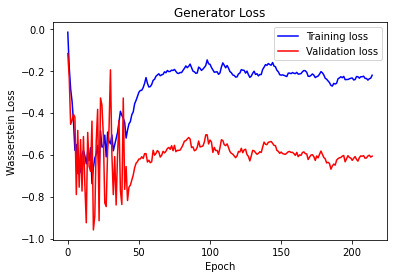

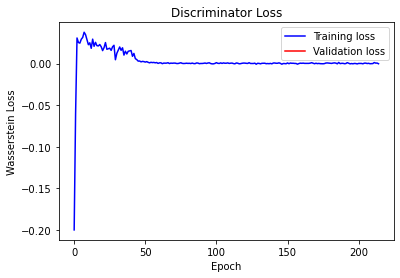

 17%|█████████████                                                                | 169/1000 [30:54<2:15:57,  9.82s/it]


Epoch 170:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


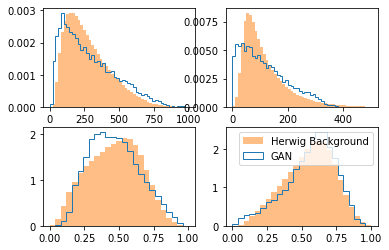

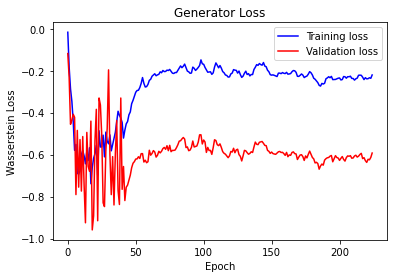

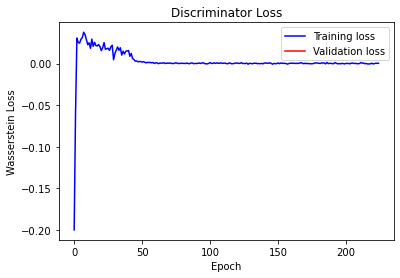

 18%|█████████████▊                                                               | 179/1000 [32:42<2:49:26, 12.38s/it]


Epoch 180:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


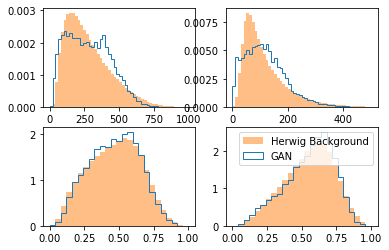

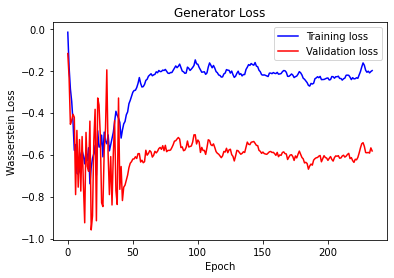

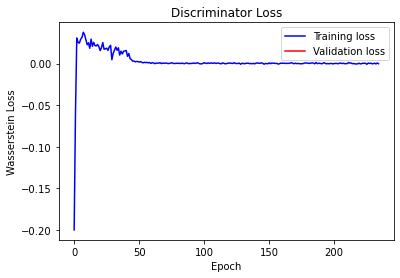

 19%|██████████████▌                                                              | 189/1000 [35:01<3:10:29, 14.09s/it]


Epoch 190:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


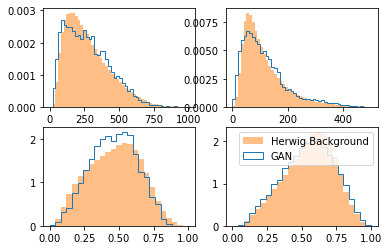

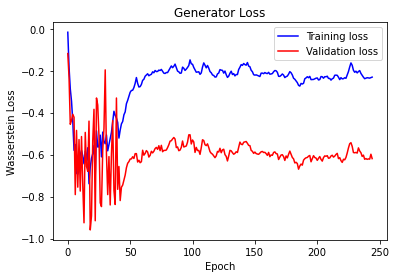

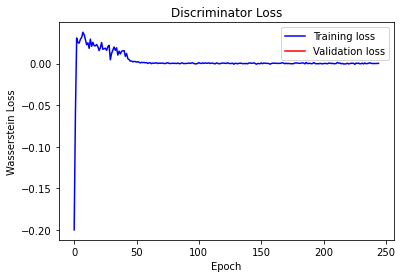

 20%|███████████████▎                                                             | 199/1000 [36:58<2:14:02, 10.04s/it]


Epoch 200:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


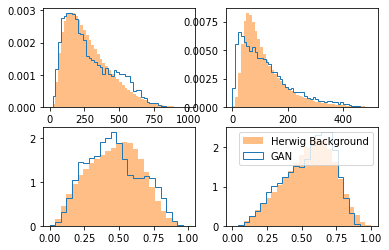

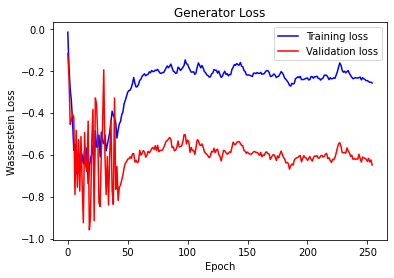

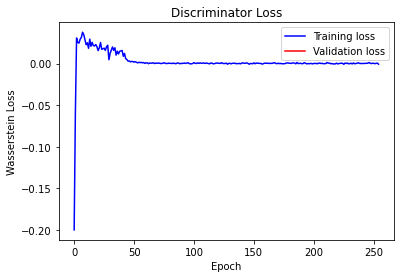

 21%|████████████████                                                             | 209/1000 [38:33<2:04:30,  9.44s/it]


Epoch 210:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


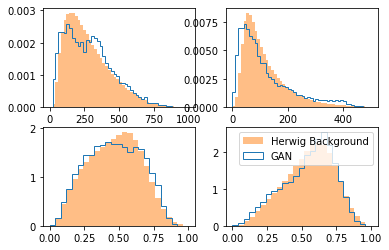

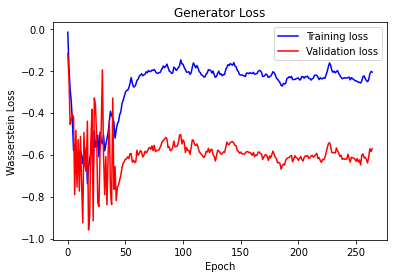

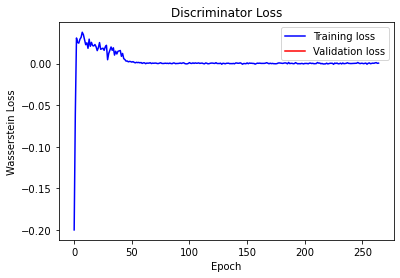

 22%|████████████████▊                                                            | 219/1000 [40:28<2:38:39, 12.19s/it]


Epoch 220:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


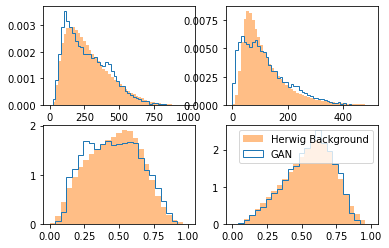

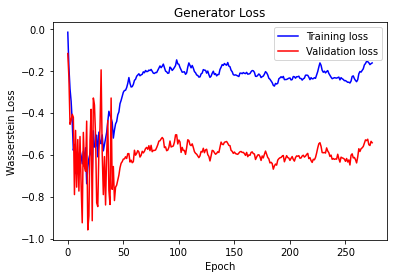

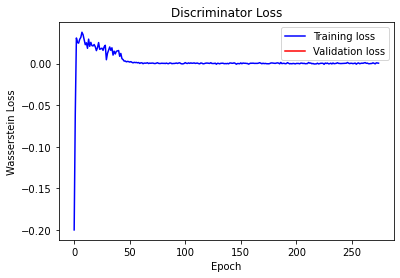

 23%|█████████████████▋                                                           | 229/1000 [42:33<2:41:56, 12.60s/it]


Epoch 230:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


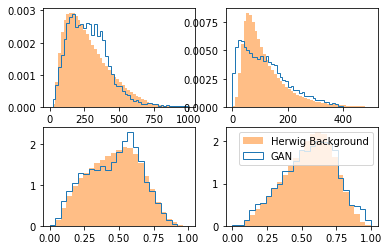

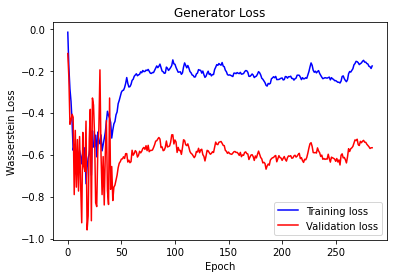

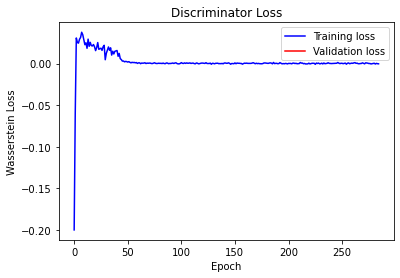

 24%|██████████████████▍                                                          | 239/1000 [44:34<2:27:53, 11.66s/it]


Epoch 240:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


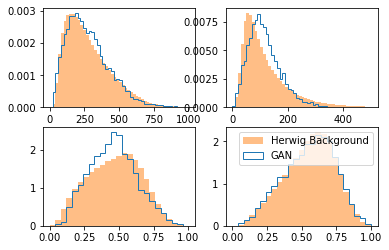

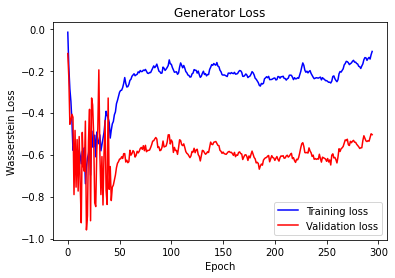

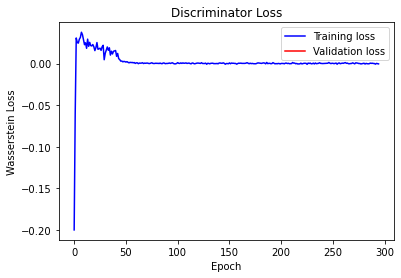

 25%|███████████████████▏                                                         | 249/1000 [46:43<2:41:21, 12.89s/it]


Epoch 250:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


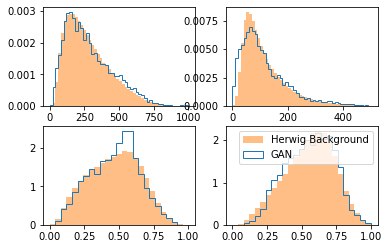

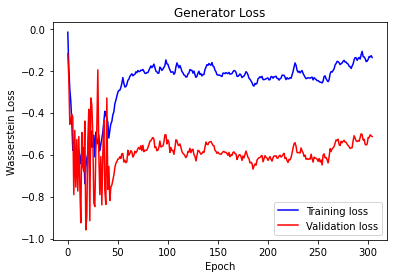

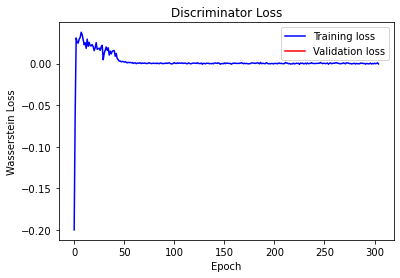

 26%|███████████████████▉                                                         | 259/1000 [48:52<2:38:35, 12.84s/it]


Epoch 260:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


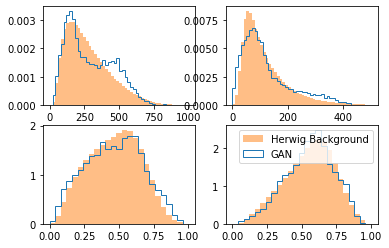

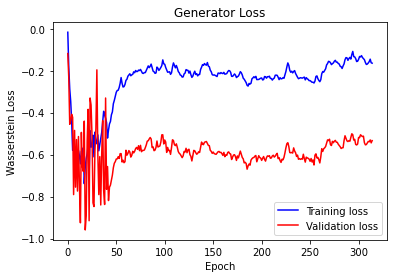

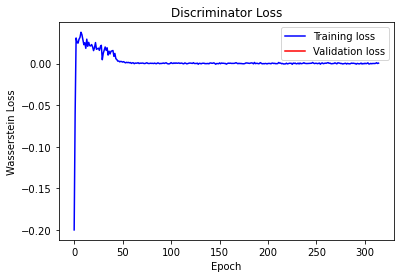

 27%|████████████████████▋                                                        | 269/1000 [51:00<2:35:04, 12.73s/it]


Epoch 270:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


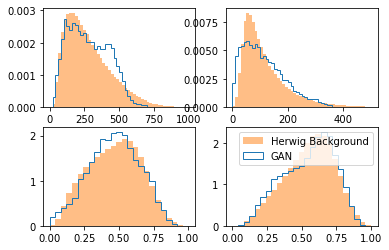

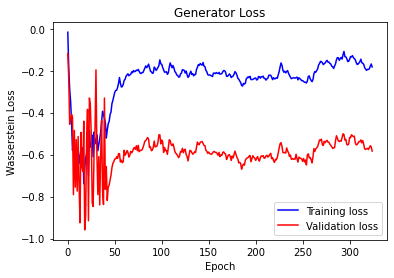

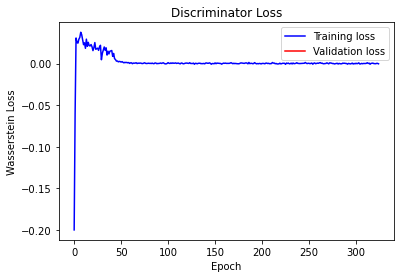

 28%|█████████████████████▍                                                       | 279/1000 [53:08<2:32:08, 12.66s/it]


Epoch 280:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


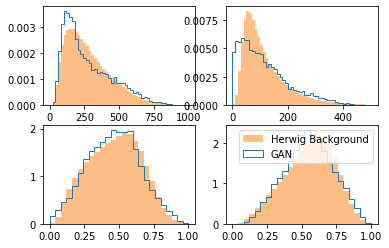

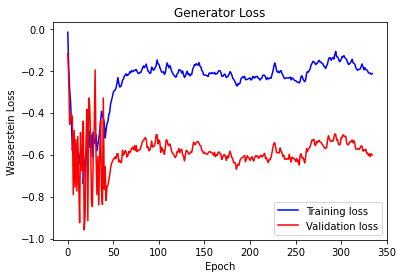

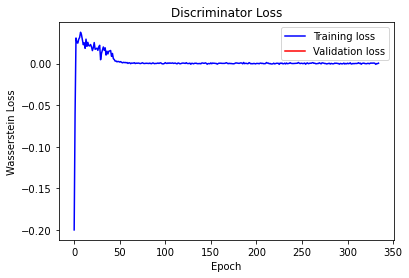

 29%|██████████████████████▎                                                      | 289/1000 [55:17<2:30:48, 12.73s/it]


Epoch 290:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


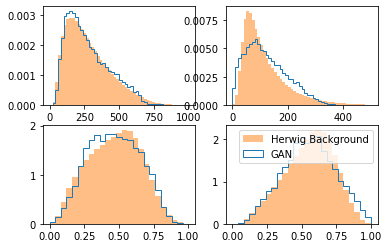

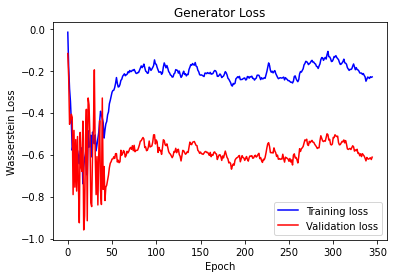

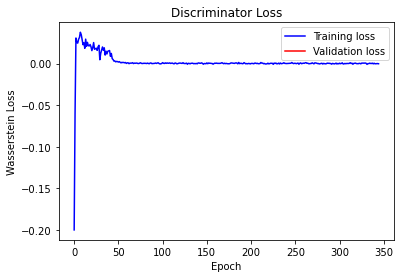

 30%|███████████████████████                                                      | 299/1000 [57:25<2:28:48, 12.74s/it]


Epoch 300:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


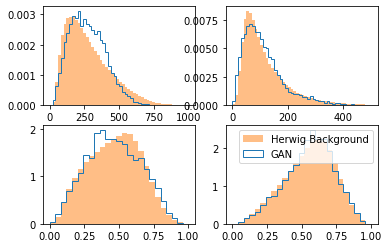

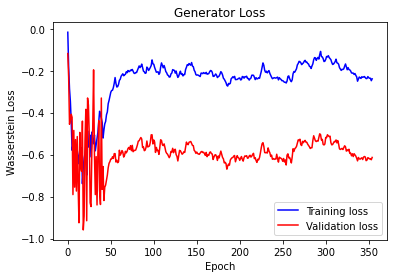

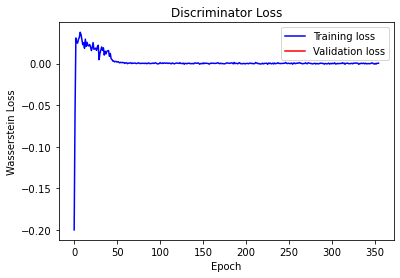

 31%|███████████████████████▊                                                     | 309/1000 [59:33<2:28:31, 12.90s/it]


Epoch 310:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


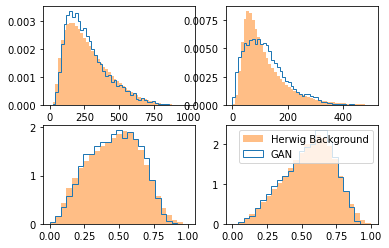

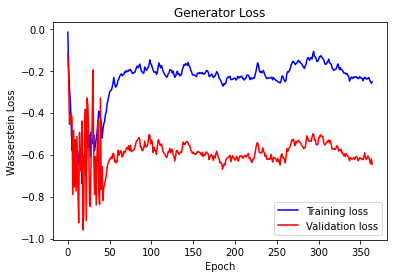

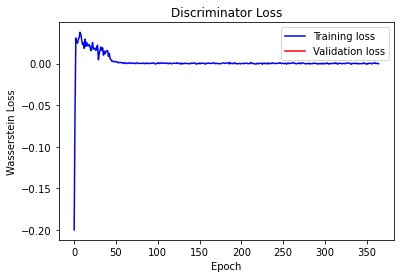

 32%|███████████████████████▉                                                   | 319/1000 [1:01:47<2:27:37, 13.01s/it]


Epoch 320:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


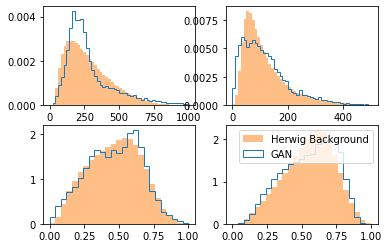

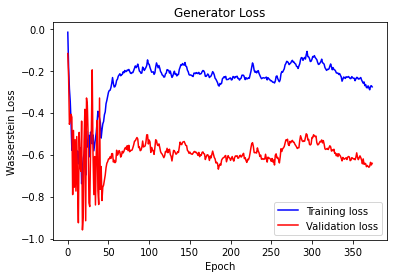

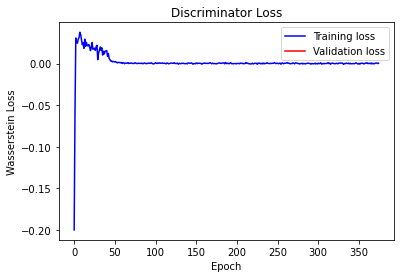

 33%|████████████████████████▋                                                  | 329/1000 [1:03:56<2:23:00, 12.79s/it]


Epoch 330:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


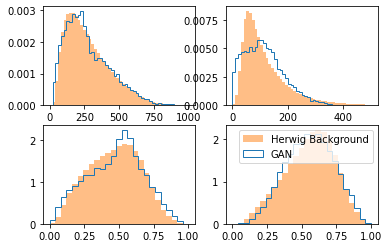

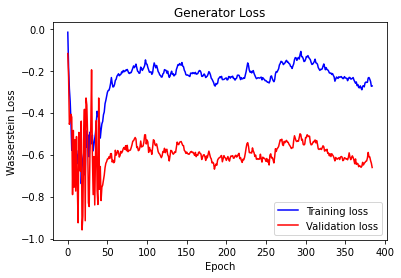

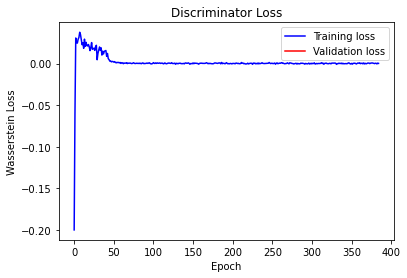

 34%|█████████████████████████▍                                                 | 339/1000 [1:06:05<2:22:36, 12.94s/it]


Epoch 340:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


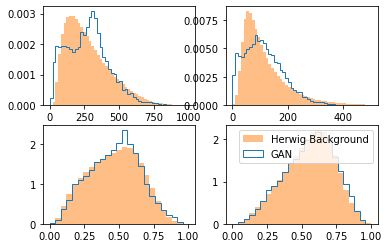

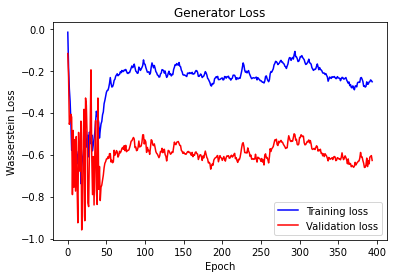

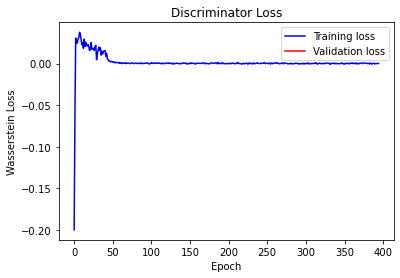

 35%|██████████████████████████▏                                                | 349/1000 [1:08:15<2:21:09, 13.01s/it]


Epoch 350:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


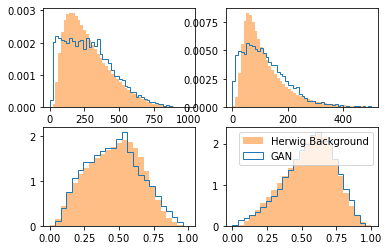

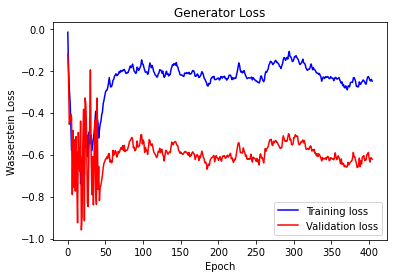

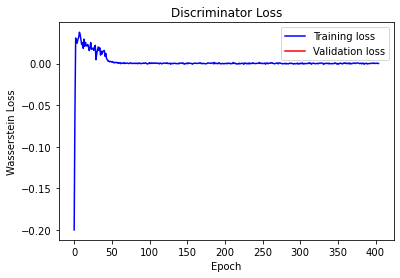

 36%|██████████████████████████▉                                                | 359/1000 [1:10:25<2:19:07, 13.02s/it]


Epoch 360:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


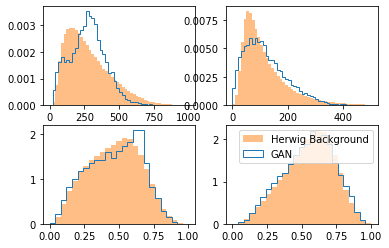

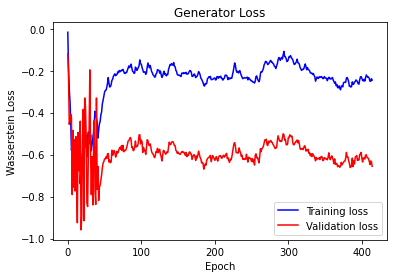

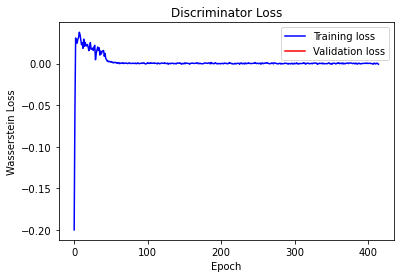

 37%|███████████████████████████▋                                               | 369/1000 [1:12:37<2:15:53, 12.92s/it]


Epoch 370:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


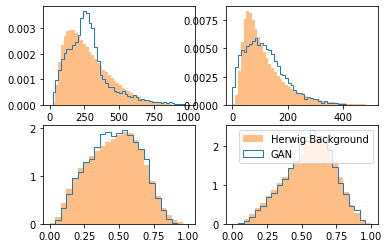

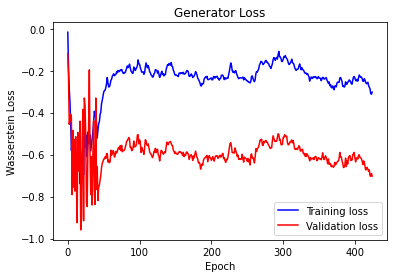

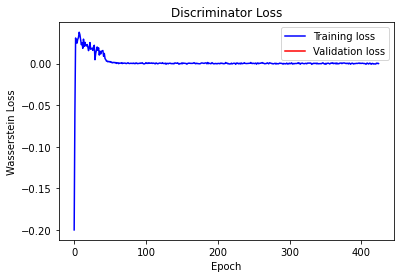

 38%|████████████████████████████▍                                              | 379/1000 [1:14:48<2:15:05, 13.05s/it]


Epoch 380:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


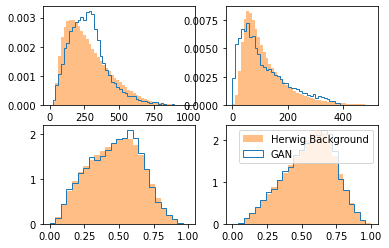

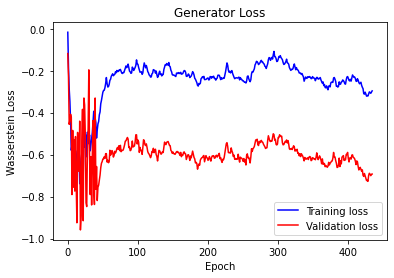

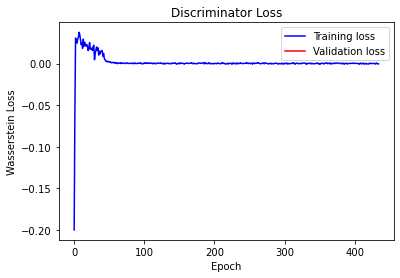

 39%|█████████████████████████████▏                                             | 389/1000 [1:16:59<2:13:18, 13.09s/it]


Epoch 390:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


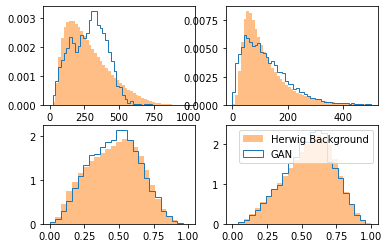

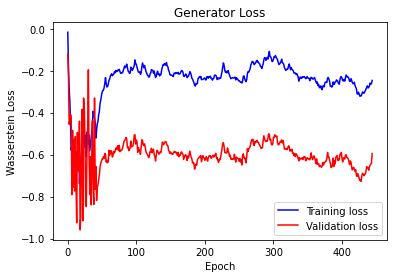

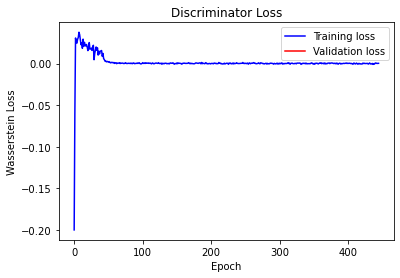

 40%|█████████████████████████████▉                                             | 399/1000 [1:19:09<2:09:05, 12.89s/it]


Epoch 400:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


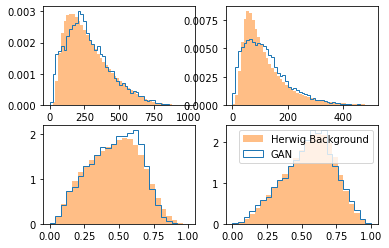

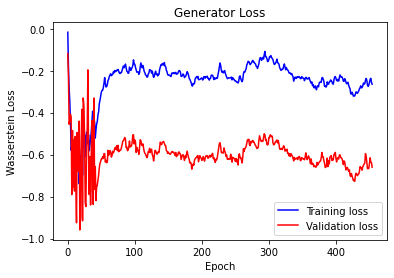

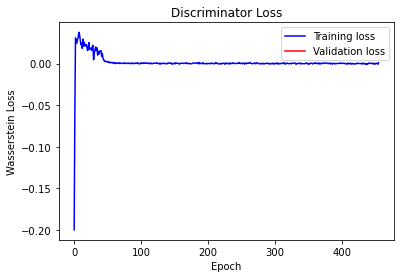

 41%|██████████████████████████████▋                                            | 409/1000 [1:21:25<2:11:00, 13.30s/it]


Epoch 410:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


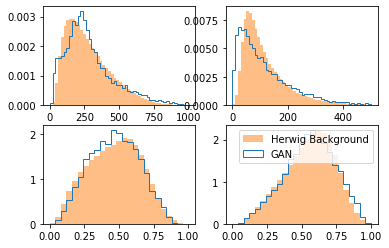

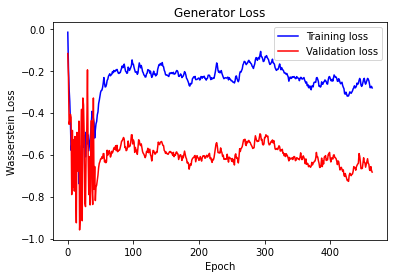

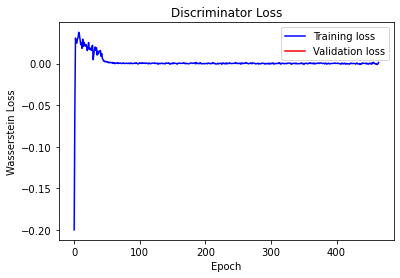

 42%|███████████████████████████████▍                                           | 419/1000 [1:23:38<2:10:20, 13.46s/it]


Epoch 420:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


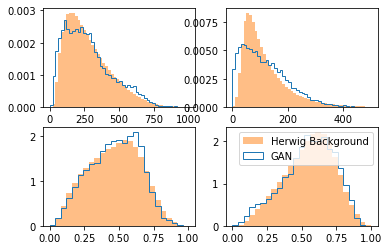

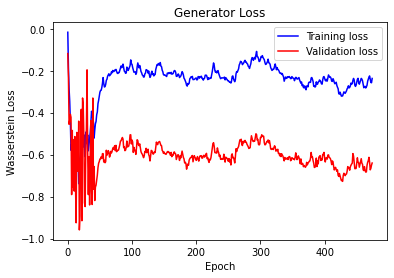

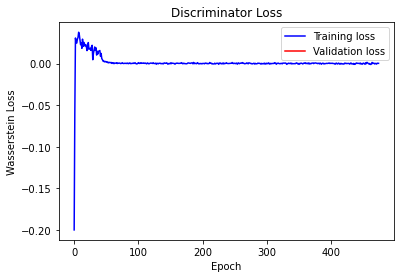

 43%|████████████████████████████████▏                                          | 429/1000 [1:25:39<1:40:38, 10.57s/it]


Epoch 430:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


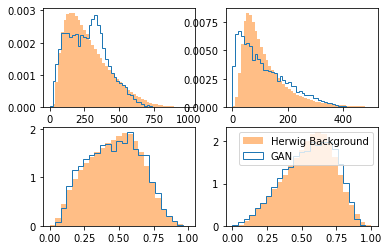

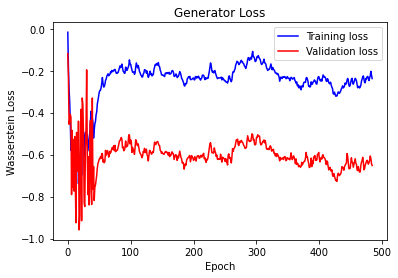

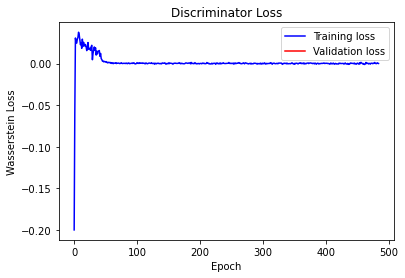

 44%|████████████████████████████████▉                                          | 439/1000 [1:27:15<1:29:21,  9.56s/it]


Epoch 440:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


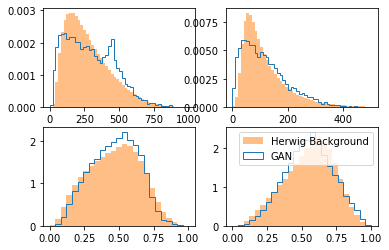

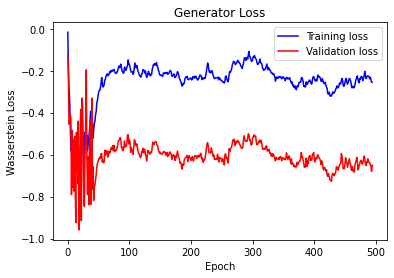

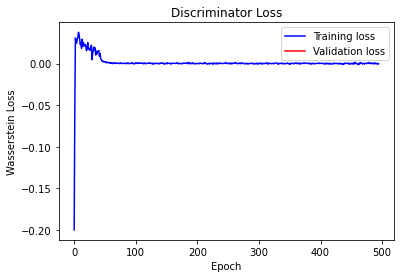

 45%|█████████████████████████████████▋                                         | 449/1000 [1:28:51<1:27:21,  9.51s/it]


Epoch 450:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


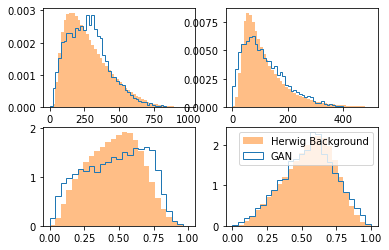

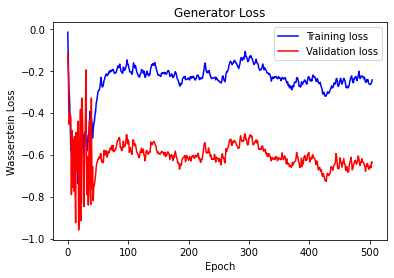

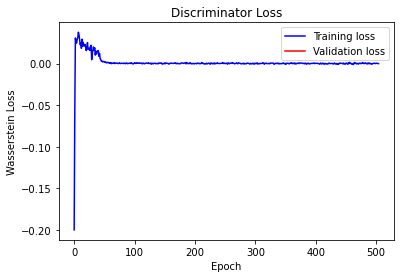

 46%|██████████████████████████████████▍                                        | 459/1000 [1:30:28<1:26:10,  9.56s/it]


Epoch 460:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


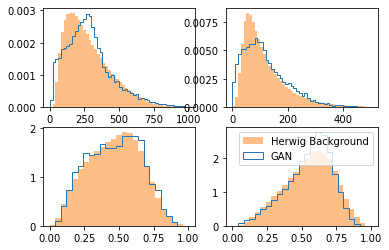

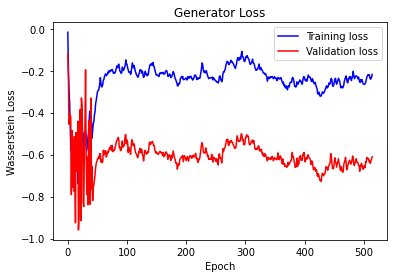

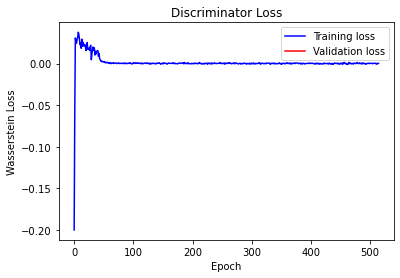

 47%|███████████████████████████████████▏                                       | 469/1000 [1:32:05<1:25:29,  9.66s/it]


Epoch 470:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


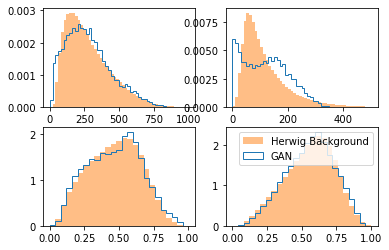

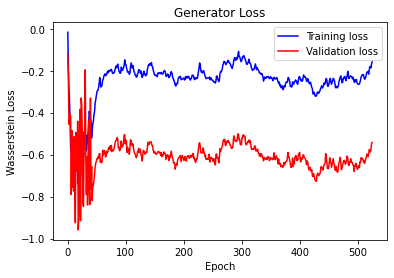

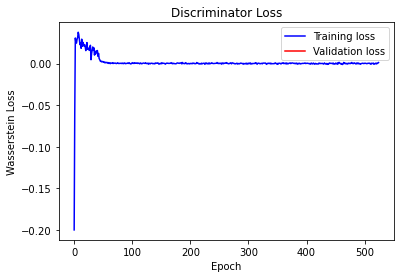

 48%|███████████████████████████████████▉                                       | 479/1000 [1:33:41<1:23:50,  9.66s/it]


Epoch 480:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


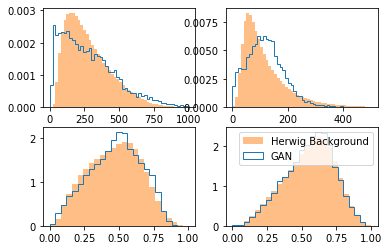

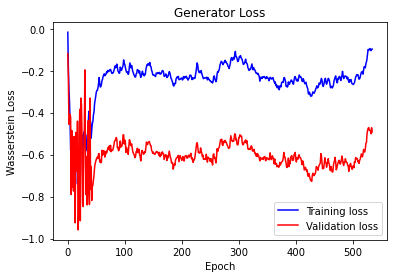

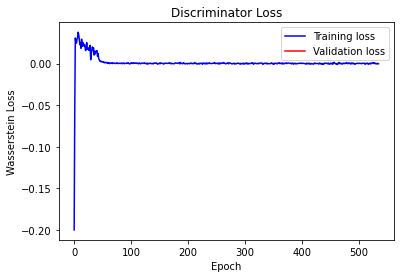

 49%|████████████████████████████████████▋                                      | 489/1000 [1:35:18<1:22:13,  9.65s/it]


Epoch 490:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


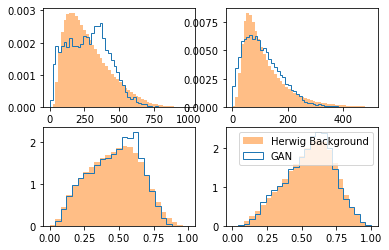

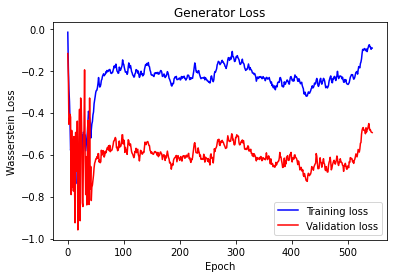

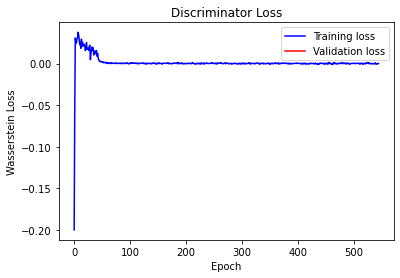

 50%|█████████████████████████████████████▍                                     | 499/1000 [1:36:56<1:21:01,  9.70s/it]


Epoch 500:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


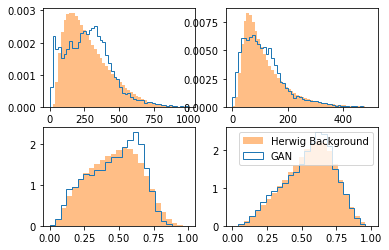

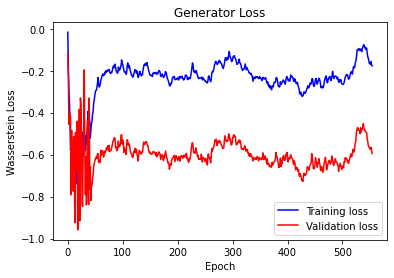

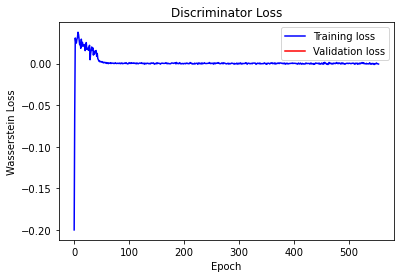

 51%|██████████████████████████████████████▏                                    | 509/1000 [1:38:33<1:19:15,  9.68s/it]


Epoch 510:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


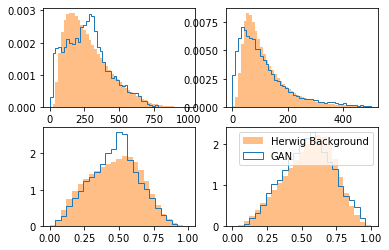

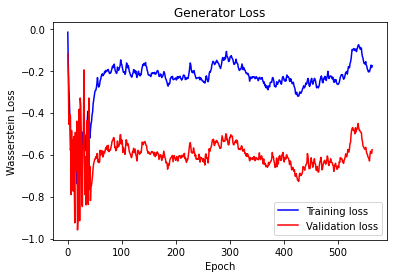

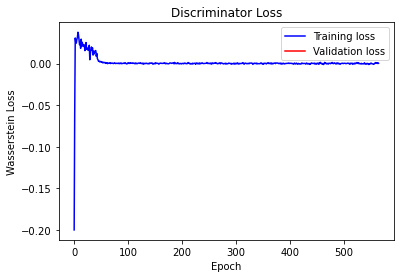

 52%|██████████████████████████████████████▉                                    | 519/1000 [1:40:10<1:18:30,  9.79s/it]


Epoch 520:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


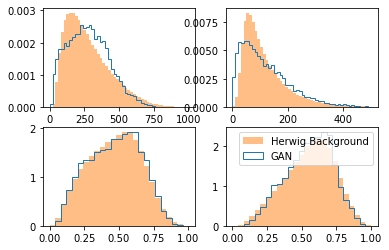

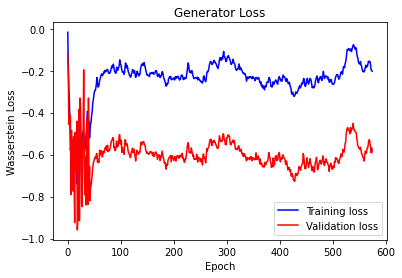

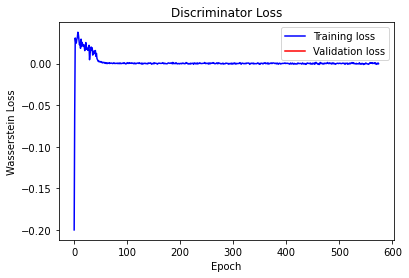

 53%|███████████████████████████████████████▋                                   | 529/1000 [1:41:47<1:14:57,  9.55s/it]


Epoch 530:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


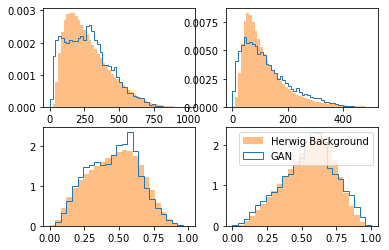

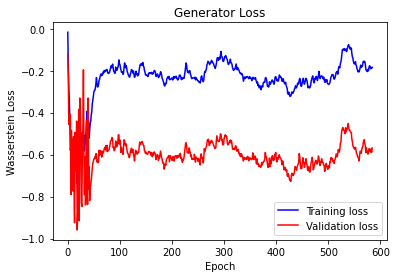

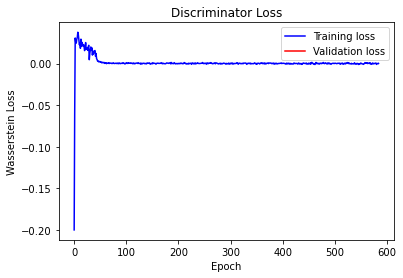

 54%|████████████████████████████████████████▍                                  | 539/1000 [1:43:23<1:13:12,  9.53s/it]


Epoch 540:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


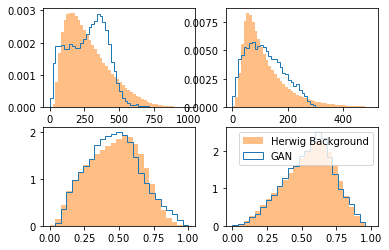

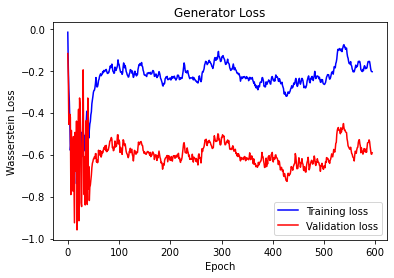

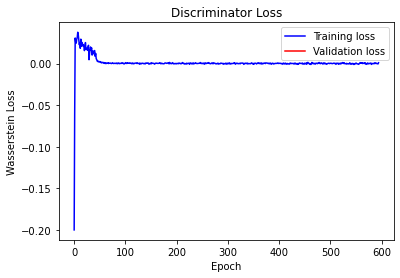

 55%|█████████████████████████████████████████▏                                 | 549/1000 [1:44:58<1:11:12,  9.47s/it]


Epoch 550:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


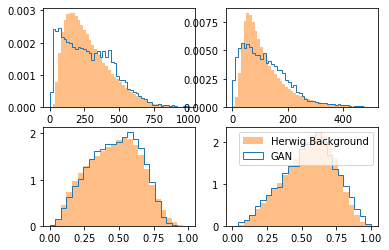

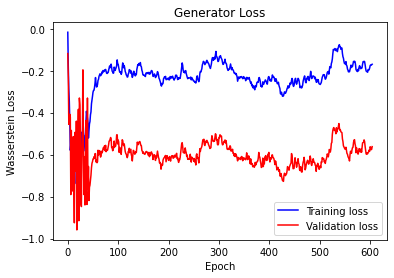

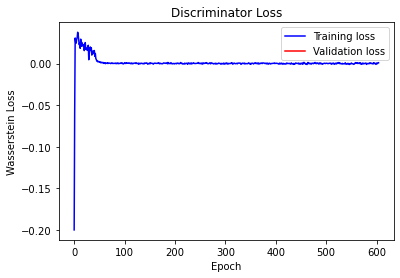

 56%|█████████████████████████████████████████▉                                 | 559/1000 [1:46:33<1:09:31,  9.46s/it]


Epoch 560:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


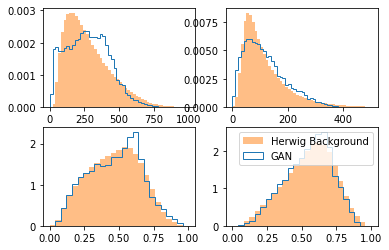

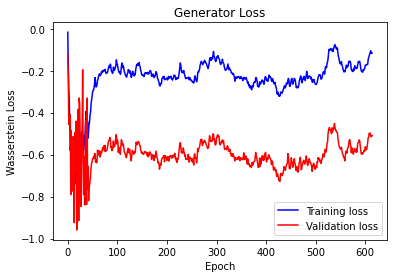

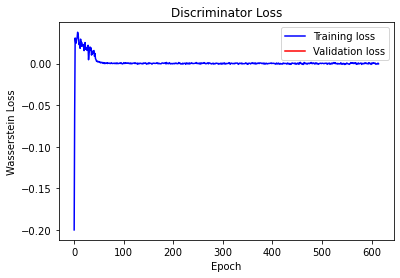

 57%|██████████████████████████████████████████▋                                | 569/1000 [1:48:09<1:08:01,  9.47s/it]


Epoch 570:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


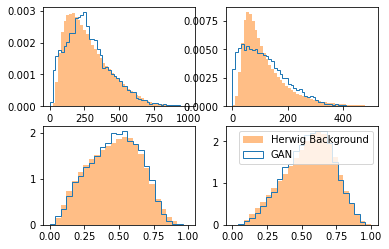

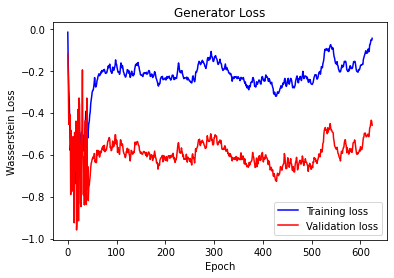

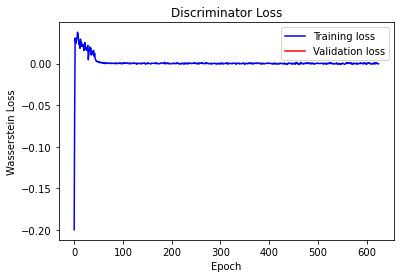

 58%|███████████████████████████████████████████▍                               | 579/1000 [1:49:44<1:06:32,  9.48s/it]


Epoch 580:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


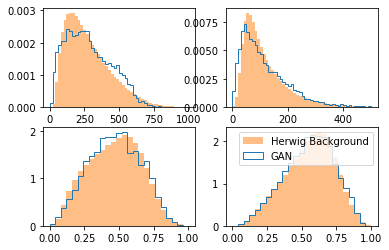

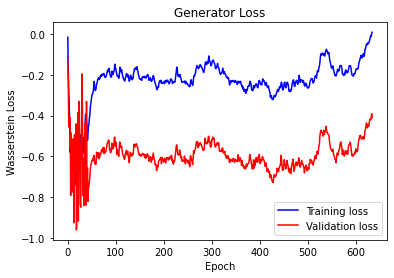

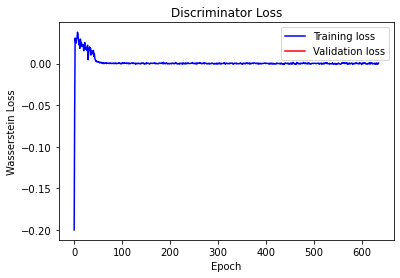

 59%|████████████████████████████████████████████▏                              | 589/1000 [1:51:20<1:05:04,  9.50s/it]


Epoch 590:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


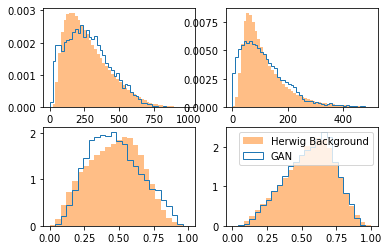

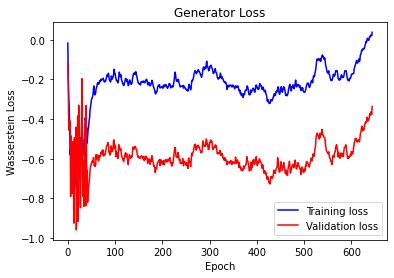

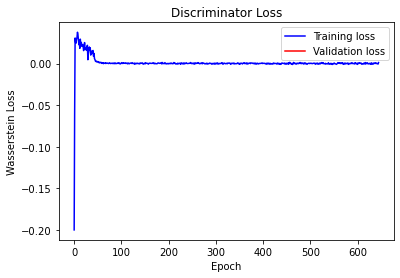

 60%|████████████████████████████████████████████▉                              | 599/1000 [1:53:01<1:05:32,  9.81s/it]


Epoch 600:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


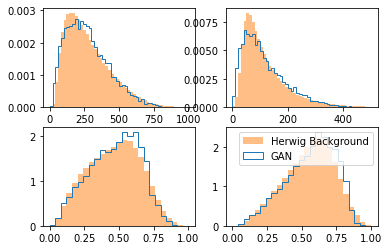

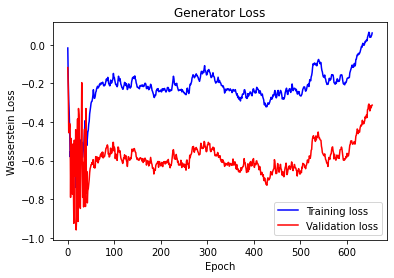

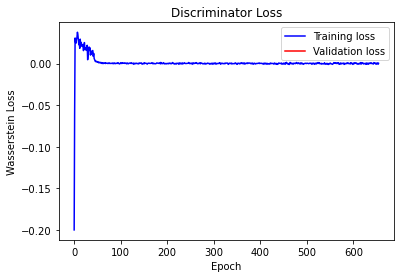

 61%|█████████████████████████████████████████████▋                             | 609/1000 [1:54:35<1:01:17,  9.40s/it]


Epoch 610:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


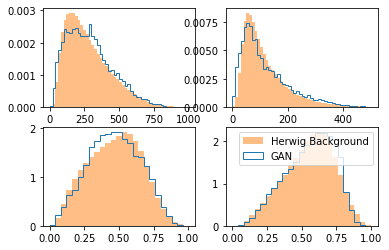

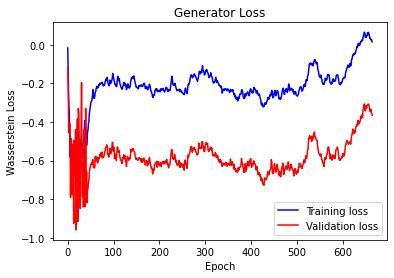

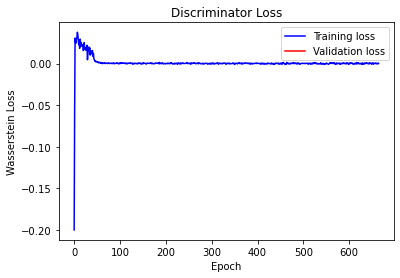

 62%|███████████████████████████████████████████████▋                             | 619/1000 [1:56:10<59:51,  9.43s/it]


Epoch 620:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


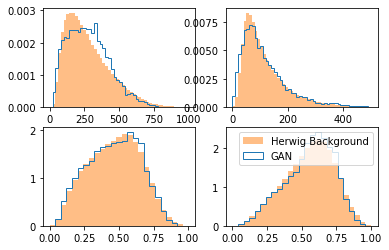

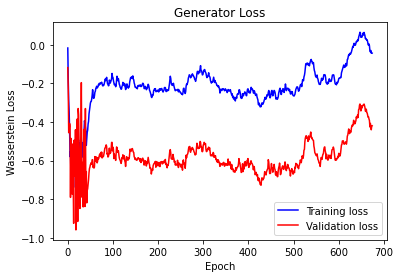

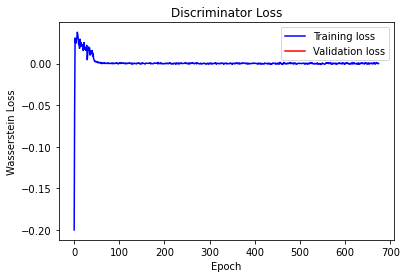

 63%|████████████████████████████████████████████████▍                            | 629/1000 [1:57:49<59:15,  9.58s/it]


Epoch 630:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


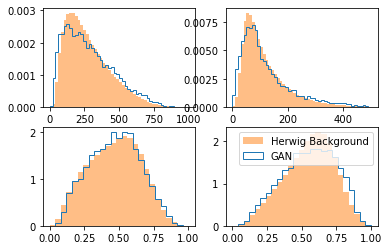

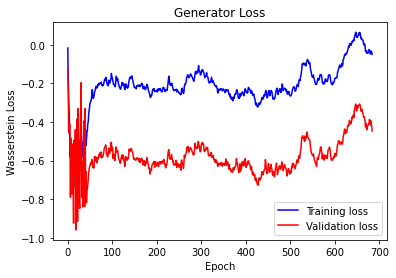

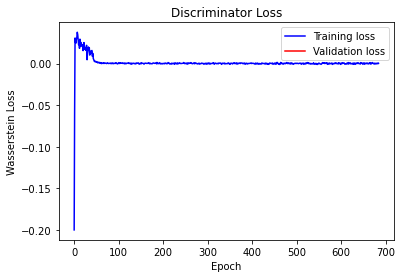

 64%|███████████████████████████████████████████████▉                           | 639/1000 [1:59:28<1:01:09, 10.16s/it]


Epoch 640:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


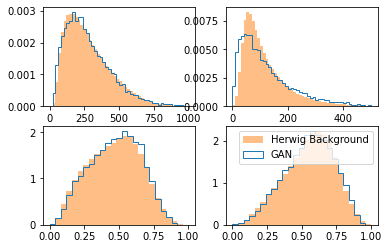

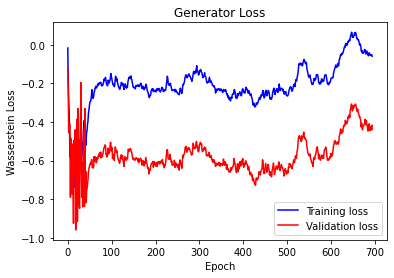

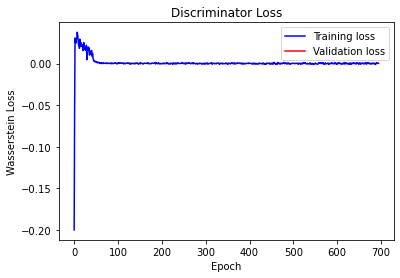

 65%|█████████████████████████████████████████████████▉                           | 649/1000 [2:01:12<58:09,  9.94s/it]


Epoch 650:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


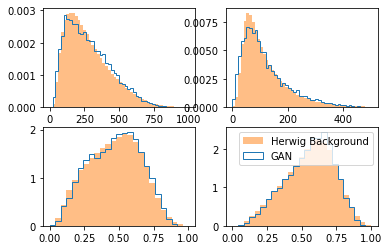

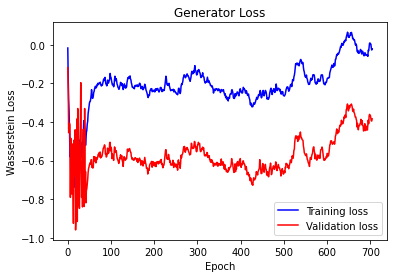

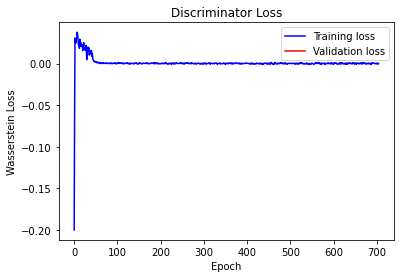

 66%|██████████████████████████████████████████████████▋                          | 659/1000 [2:02:58<59:11, 10.41s/it]


Epoch 660:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


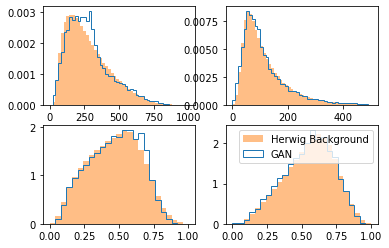

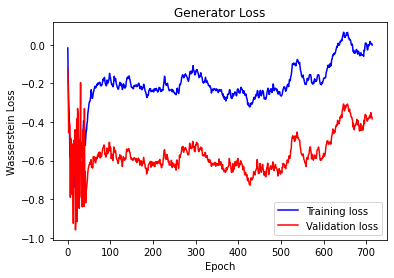

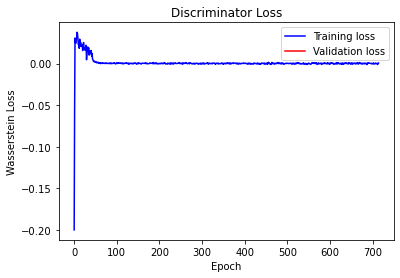

 67%|███████████████████████████████████████████████████▌                         | 669/1000 [2:04:43<57:18, 10.39s/it]


Epoch 670:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


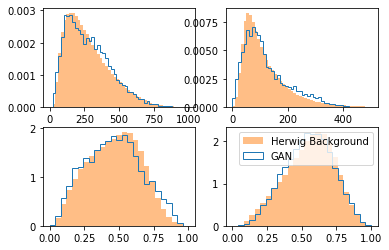

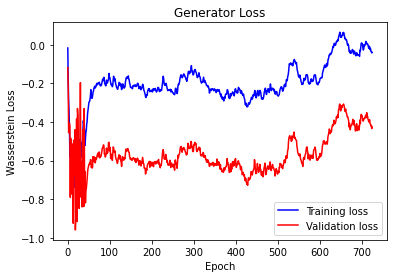

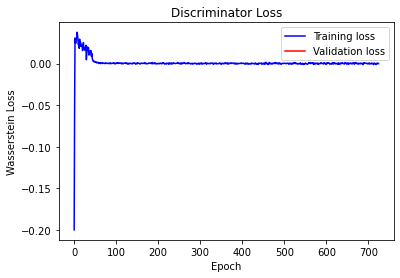

 68%|████████████████████████████████████████████████████▎                        | 679/1000 [2:06:29<55:49, 10.43s/it]


Epoch 680:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


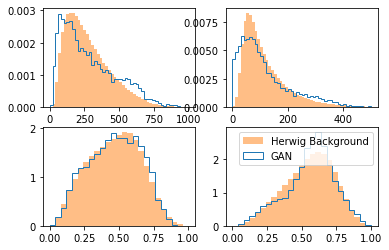

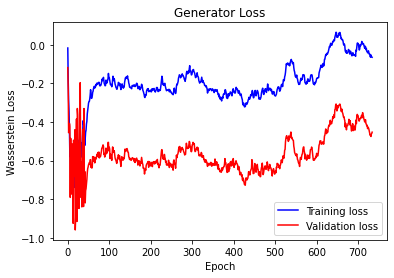

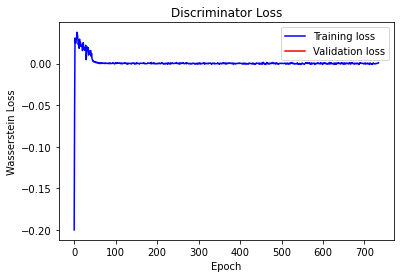

 69%|█████████████████████████████████████████████████████                        | 689/1000 [2:08:13<53:42, 10.36s/it]


Epoch 690:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


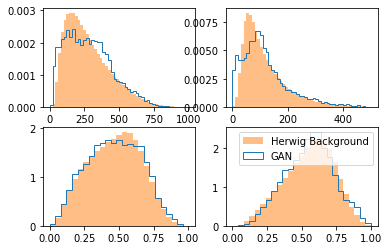

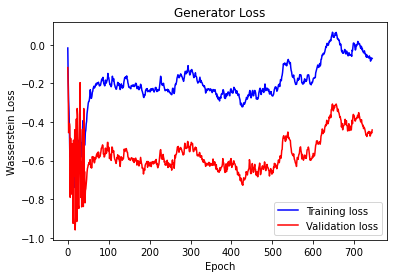

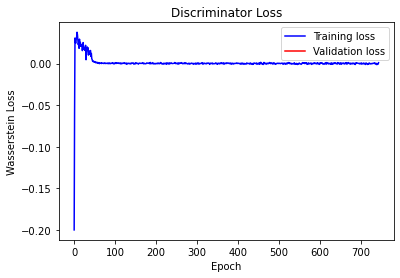

 70%|█████████████████████████████████████████████████████▊                       | 699/1000 [2:09:58<51:54, 10.35s/it]


Epoch 700:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


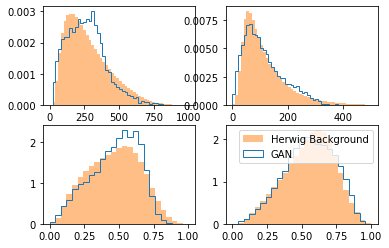

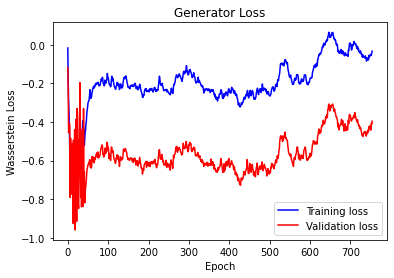

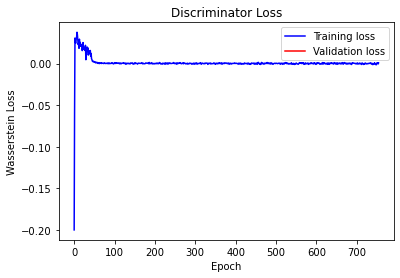

 71%|██████████████████████████████████████████████████████▌                      | 709/1000 [2:11:41<50:02, 10.32s/it]


Epoch 710:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


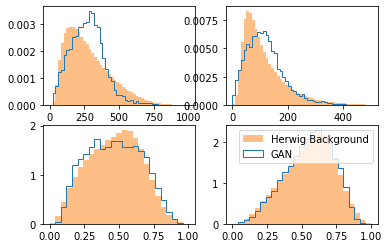

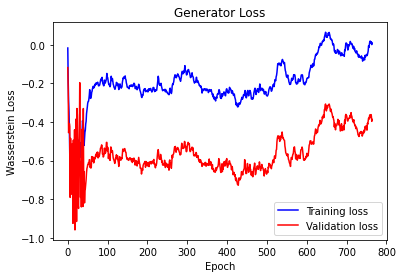

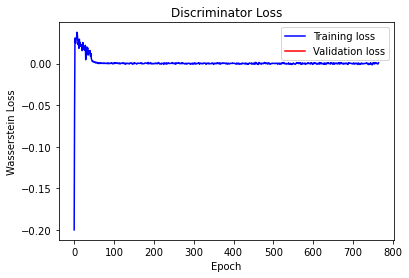

 72%|███████████████████████████████████████████████████████▎                     | 719/1000 [2:13:24<47:52, 10.22s/it]


Epoch 720:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


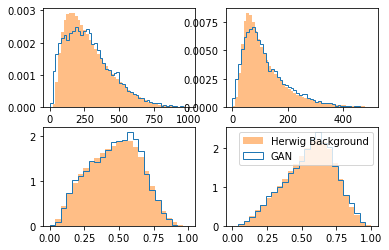

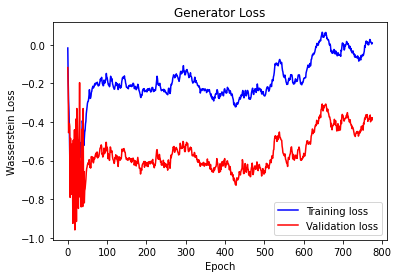

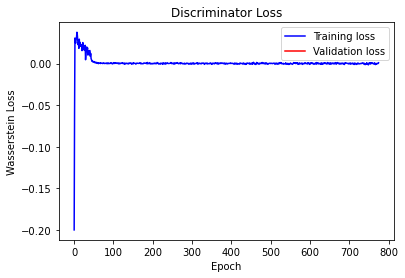

 73%|████████████████████████████████████████████████████████▏                    | 729/1000 [2:15:08<46:36, 10.32s/it]


Epoch 730:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


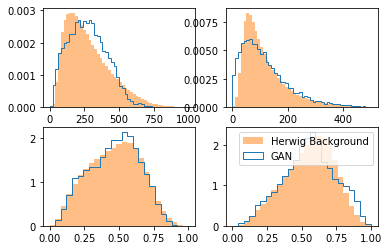

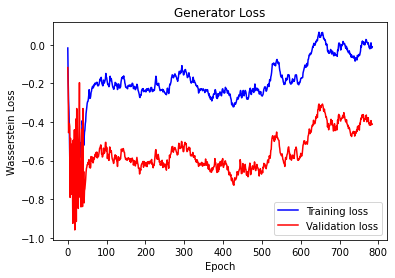

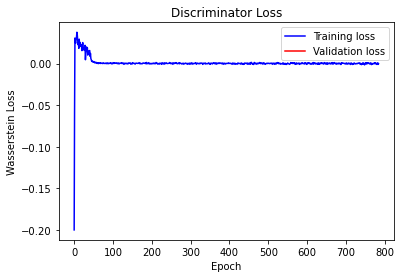

 74%|████████████████████████████████████████████████████████▉                    | 739/1000 [2:16:53<45:07, 10.37s/it]


Epoch 740:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


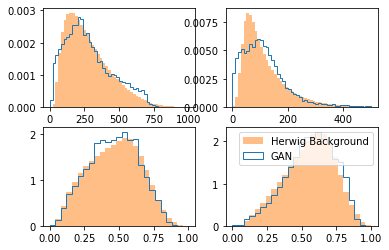

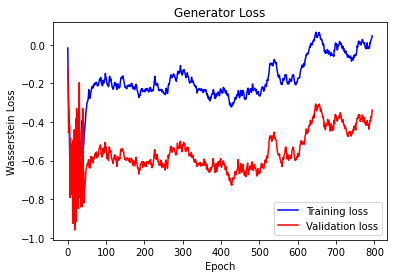

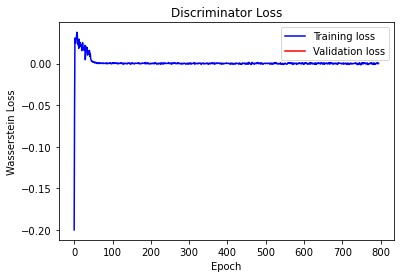

 75%|█████████████████████████████████████████████████████████▋                   | 749/1000 [2:18:41<45:06, 10.78s/it]


Epoch 750:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


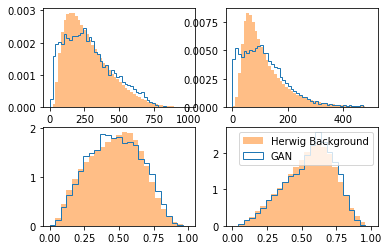

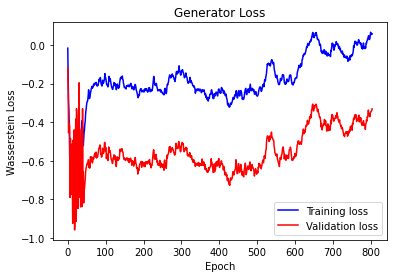

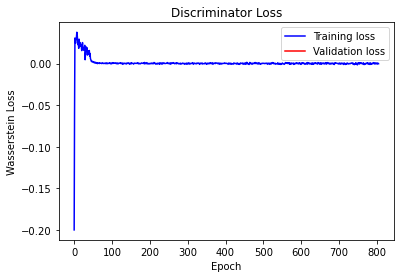

 76%|██████████████████████████████████████████████████████████▍                  | 759/1000 [2:20:38<47:42, 11.88s/it]


Epoch 760:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


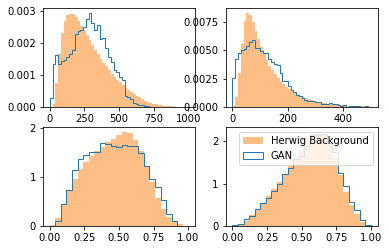

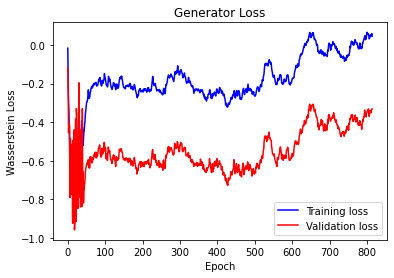

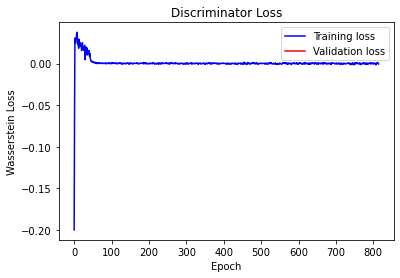

 77%|███████████████████████████████████████████████████████████▏                 | 769/1000 [2:22:37<45:39, 11.86s/it]


Epoch 770:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


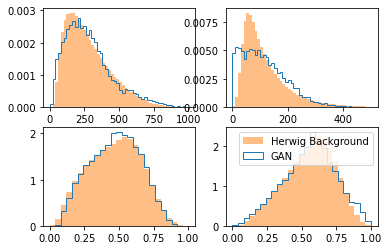

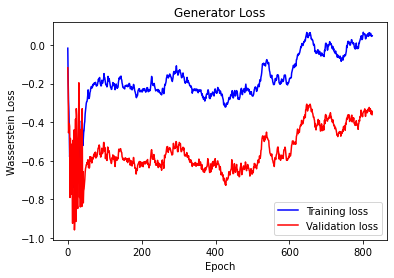

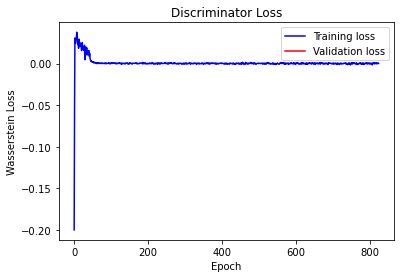

 78%|███████████████████████████████████████████████████████████▉                 | 779/1000 [2:24:41<45:18, 12.30s/it]


Epoch 780:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


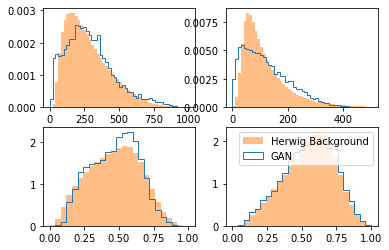

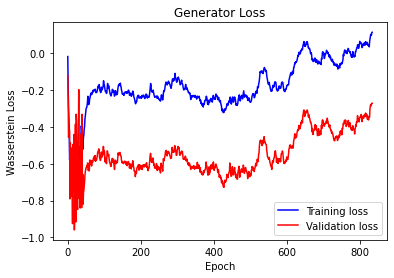

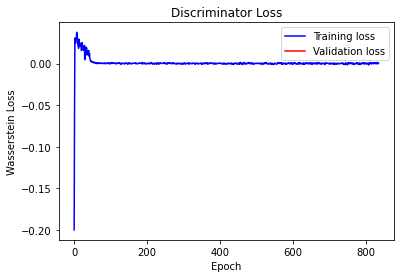

 79%|████████████████████████████████████████████████████████████▊                | 789/1000 [2:26:45<43:03, 12.24s/it]


Epoch 790:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


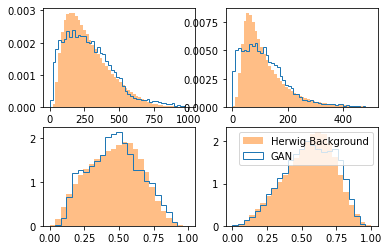

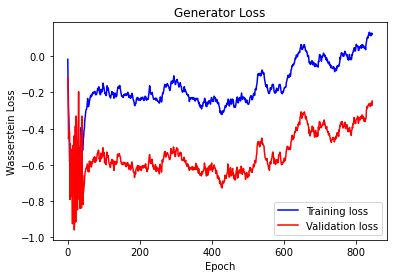

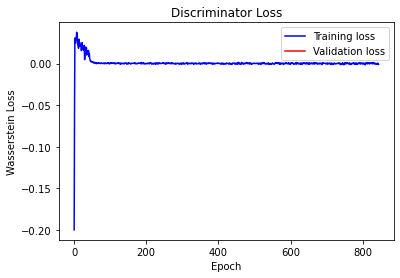

 80%|█████████████████████████████████████████████████████████████▌               | 799/1000 [2:28:39<37:00, 11.05s/it]


Epoch 800:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


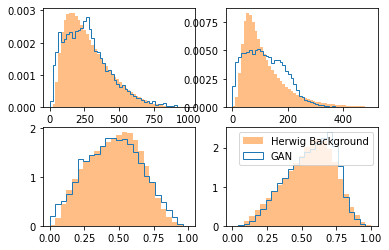

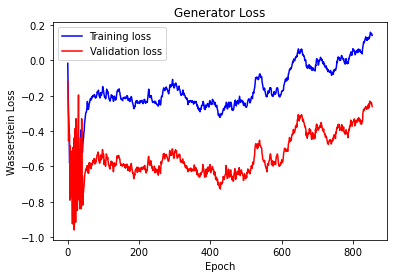

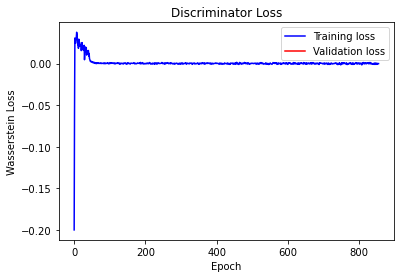

 81%|██████████████████████████████████████████████████████████████▎              | 809/1000 [2:30:36<36:42, 11.53s/it]


Epoch 810:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


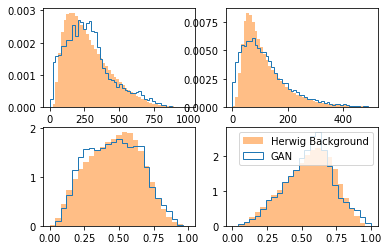

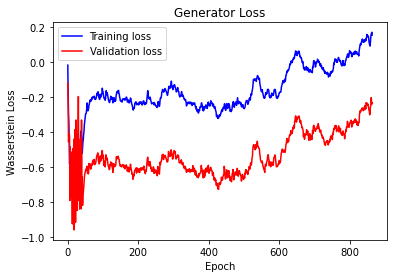

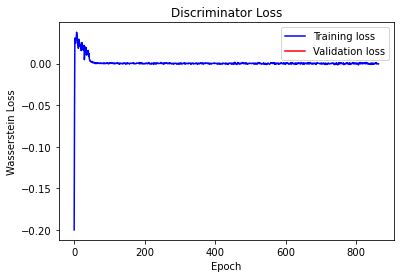

 82%|███████████████████████████████████████████████████████████████              | 819/1000 [2:32:29<33:10, 11.00s/it]


Epoch 820:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


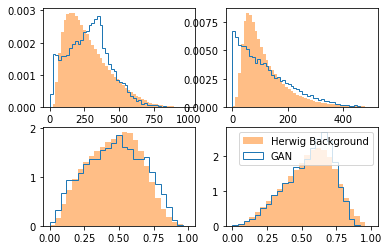

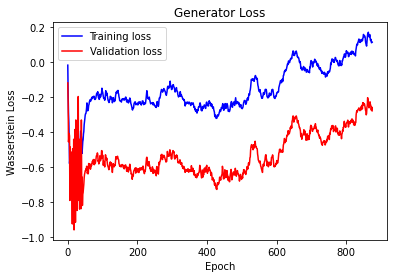

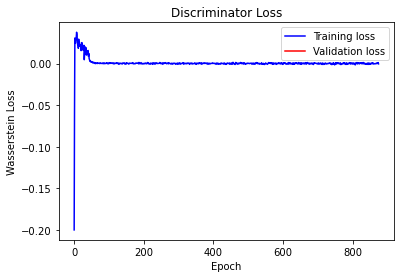

 83%|███████████████████████████████████████████████████████████████▊             | 829/1000 [2:34:19<31:37, 11.10s/it]


Epoch 830:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


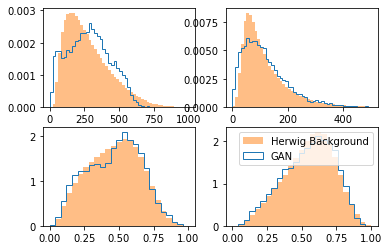

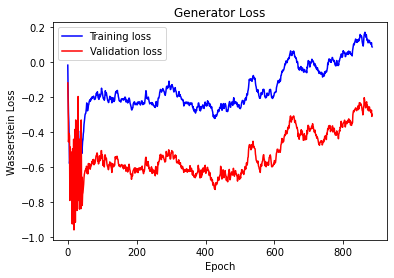

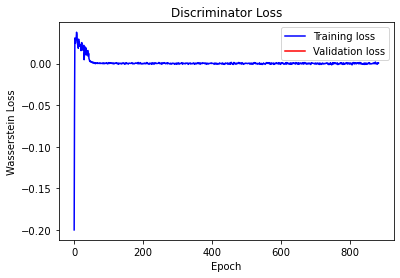

 84%|████████████████████████████████████████████████████████████████▌            | 839/1000 [2:36:14<30:24, 11.33s/it]


Epoch 840:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


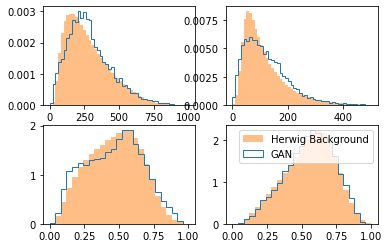

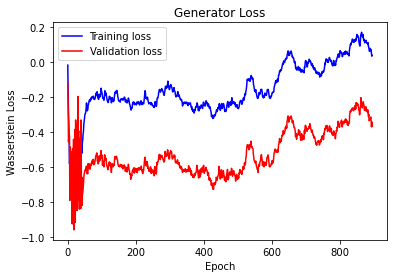

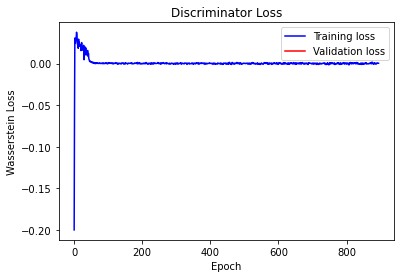

 85%|█████████████████████████████████████████████████████████████████▎           | 849/1000 [2:38:09<29:53, 11.88s/it]


Epoch 850:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


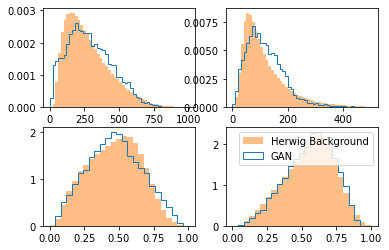

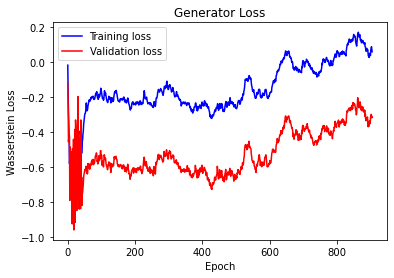

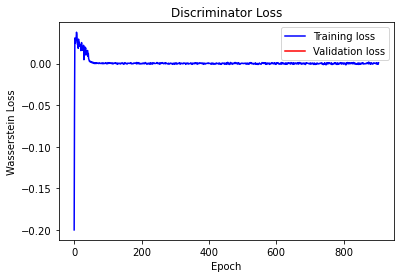

 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [2:40:03<28:24, 12.09s/it]


Epoch 860:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


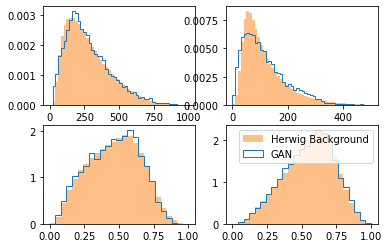

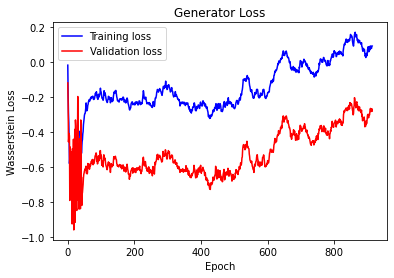

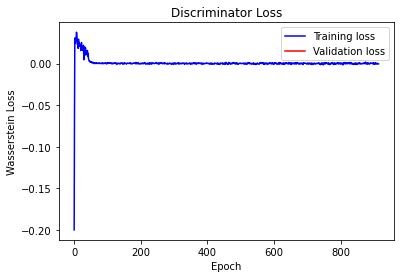

 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [2:42:09<26:53, 12.32s/it]


Epoch 870:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


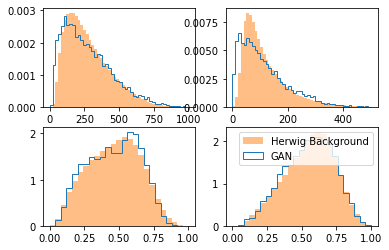

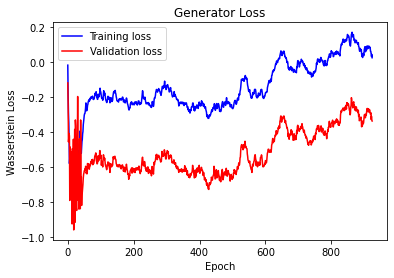

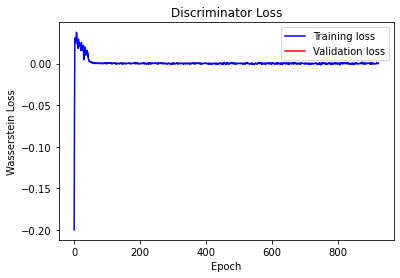

 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [2:44:13<24:54, 12.35s/it]


Epoch 880:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


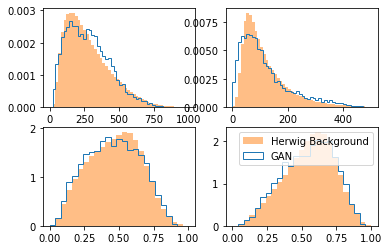

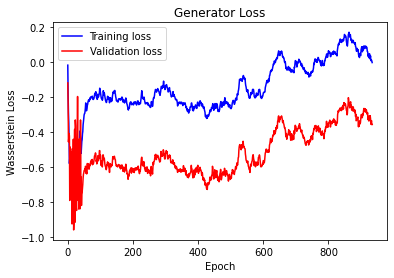

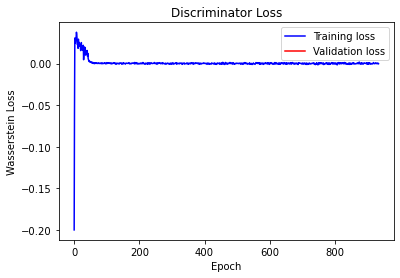

 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [2:46:17<22:55, 12.39s/it]


Epoch 890:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


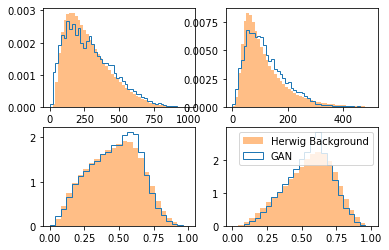

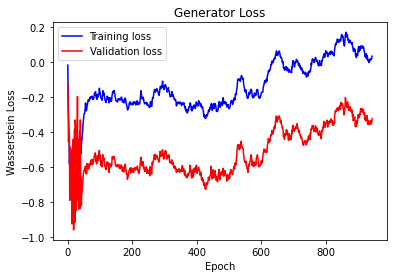

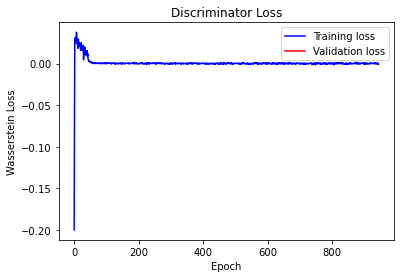

 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [2:48:21<20:47, 12.36s/it]


Epoch 900:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


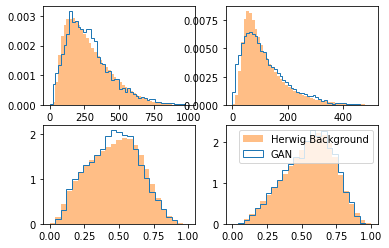

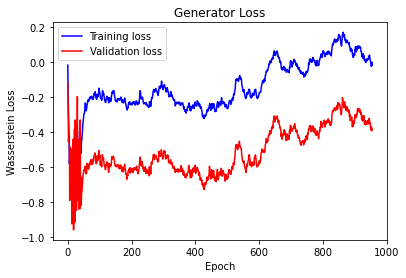

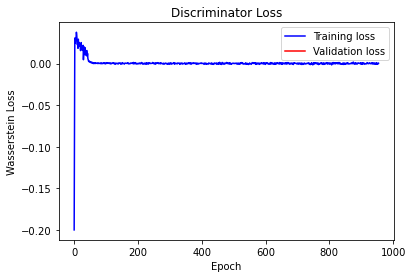

 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [2:50:25<18:57, 12.50s/it]


Epoch 910:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


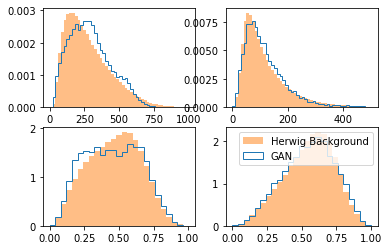

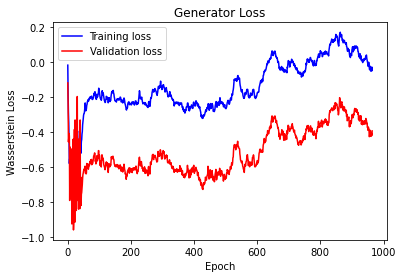

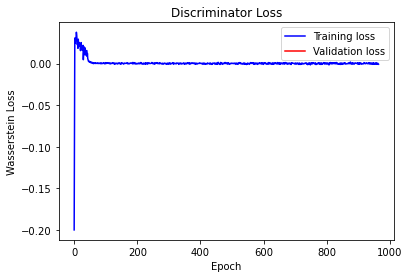

 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [2:52:30<16:41, 12.36s/it]


Epoch 920:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


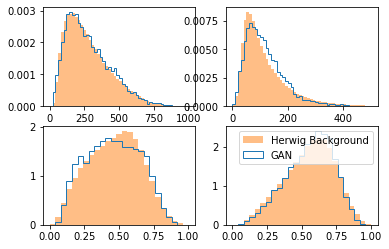

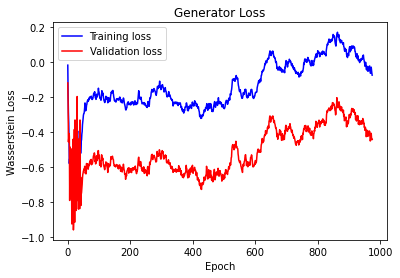

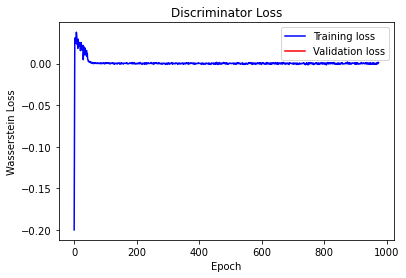

 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [2:54:35<14:42, 12.44s/it]


Epoch 930:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


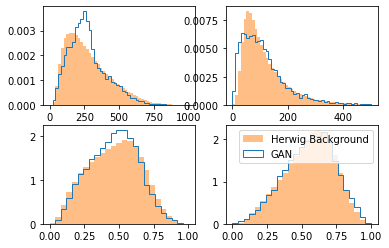

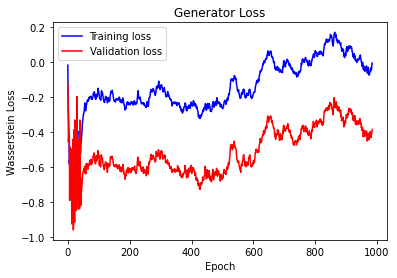

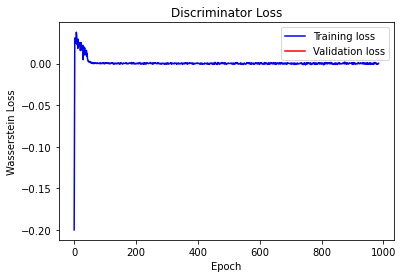

 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [2:56:39<12:32, 12.33s/it]


Epoch 940:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


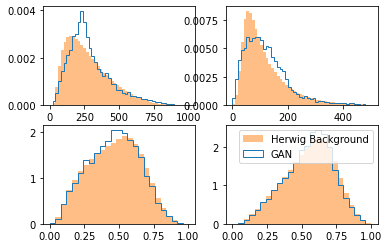

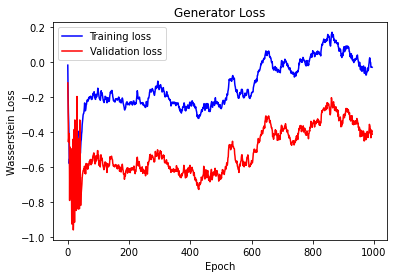

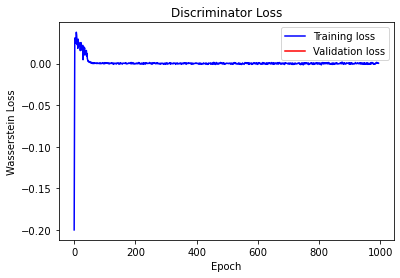

 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [2:58:45<10:31, 12.39s/it]


Epoch 950:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


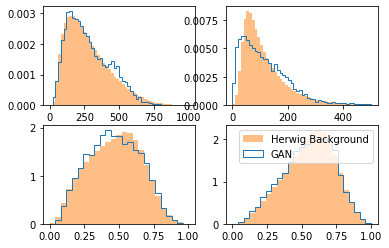

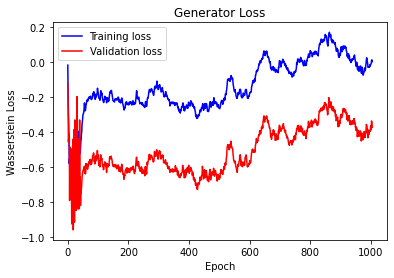

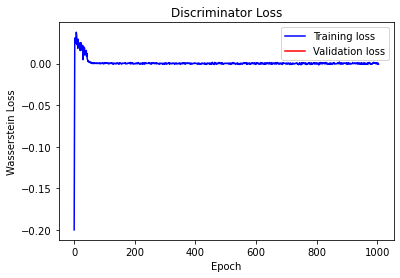

 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [3:00:53<08:49, 12.92s/it]


Epoch 960:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


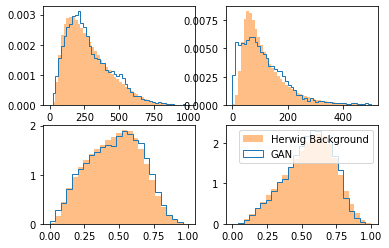

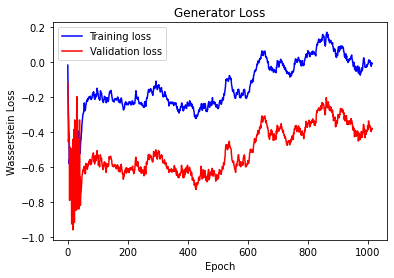

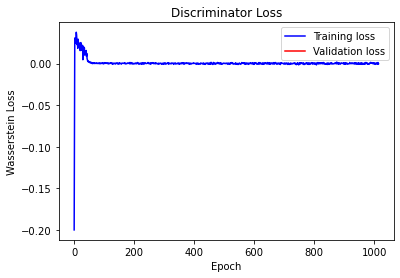

 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [3:02:59<06:29, 12.58s/it]


Epoch 970:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


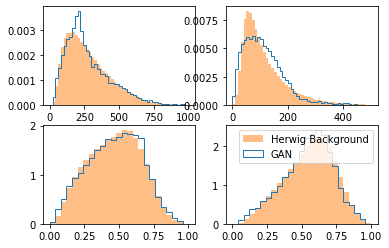

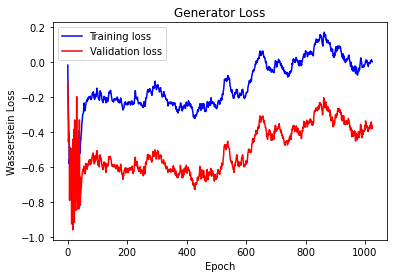

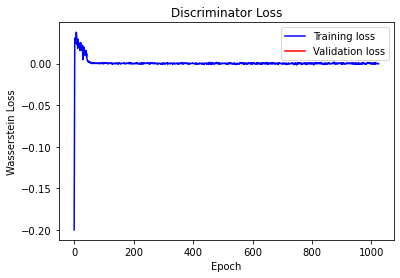

 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [3:05:07<04:26, 12.71s/it]


Epoch 980:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


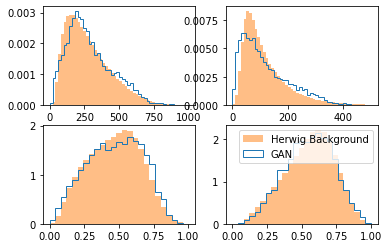

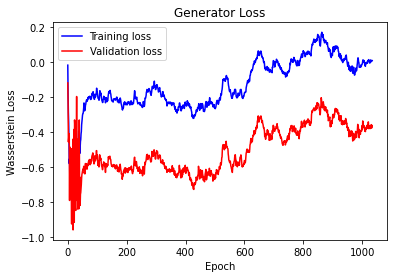

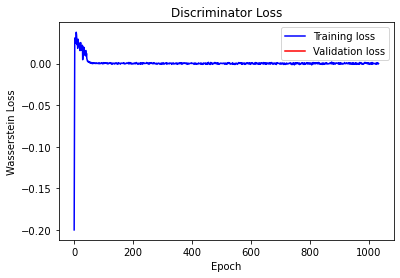

 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [3:07:15<02:22, 12.93s/it]


Epoch 990:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


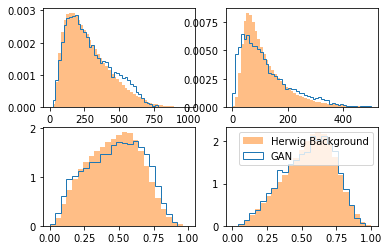

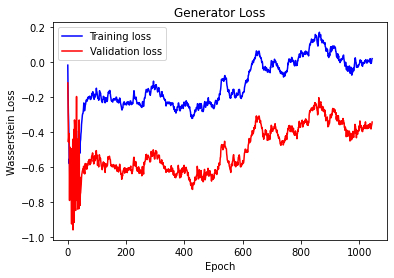

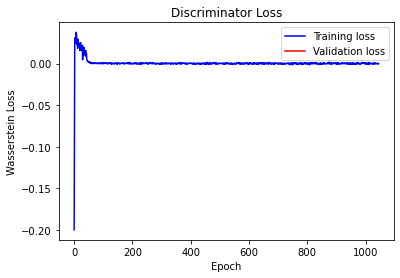

100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [3:09:20<00:12, 12.41s/it]


Epoch 1000:


C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Azure\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


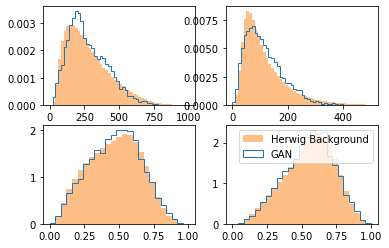

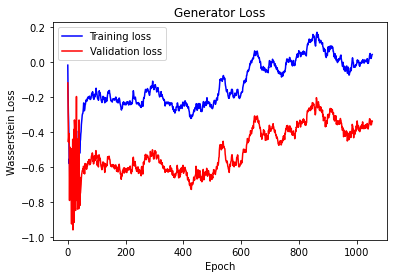

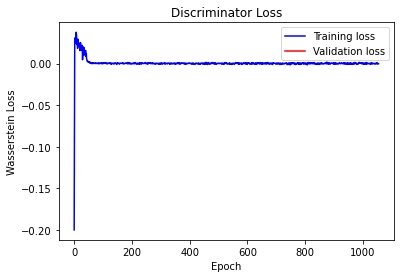

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:09:34<00:00, 11.37s/it]


In [43]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080